In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
import plotly.express as px
from matplotlib import cm
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib as mpl
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy
import random
import xarray as xr
import itertools
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn import tree
from sklearn.model_selection import cross_validate
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pathos.threading import ThreadPool as Pool
from sklearn import datasets, linear_model
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
work_dir=Path("/mnt/u/LSM root zone/global_sr/data_to_share")
fig_dir=Path('/mnt/c/Users/fransjevanoors/surfdrive - Fransje van Oorschot@surfdrive.surf.nl/Fransje/global_SR/global_sr_paper/figures')

In [3]:
data_sources = 'gswp-p_gleam-ep_gswp-t'

In [4]:
# performance metrics
def rmse(y,y_pred):
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    return rmse

def r2_adj(y,y_pred,features):
    r2 = r2_score(y, y_pred)
    r2_adj = 1-(((1-r2)*(len(y)-1))/(len(y)-len(features)-1))
    return r2_adj

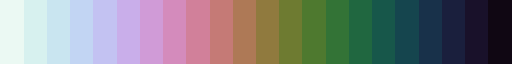

In [5]:
cmap = cm.get_cmap('cubehelix_r', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap_sr = ListedColormap(color_list[1:-1])
cmap_sr.set_over(color_list[-1])
cmap_sr.set_under(color_list[0])
cmap_sr.set_bad('lightgrey')
cmap_sr

In [6]:
# # change units of slope
# df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v2.csv',index_col=0)
# dfs = df.slp_mean
# dfs =  np.deg2rad(dfs)
# slp_p = np.tan(dfs) * 100
# df['slp_mean'] = slp_p
# df.to_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv')

## 0. plot Sr

3612


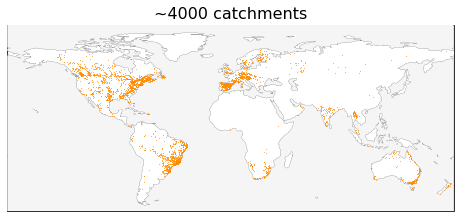

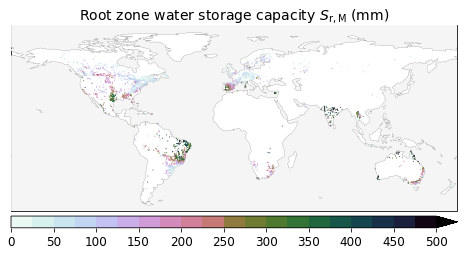

In [7]:
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df = df[['lat','lon','sr_20']]
print(len(df))

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(df.lon,df.lat,s=0.7,c='darkorange',edgecolors='face',marker='o',linewidths=0.1,zorder=102)
ax.set_title('~4000 catchments',size=16)
fig2.savefig(f'{fig_dir}/catch_locations.jpg',bbox_inches='tight',dpi=600)

bounds = np.linspace(0,500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,s=0.8,c=df['sr_20'],cmap=cmap_sr, norm=norm,edgecolors='face',marker='o',linewidths=0.1,zorder=101)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.012,aspect=38, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('Root zone water storage capacity $S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_label(label='', size=10)
fig.savefig(f'{fig_dir}/sr_memory_method.jpg',bbox_inches='tight',dpi=600)

## 1. CORRELATION MATRIX

In [8]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    # cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    # cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False,labelsize=17)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #          rotation_mode="anchor")
    
    plt.setp(ax.get_xticklabels(), rotation=30, ha="center", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    # ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

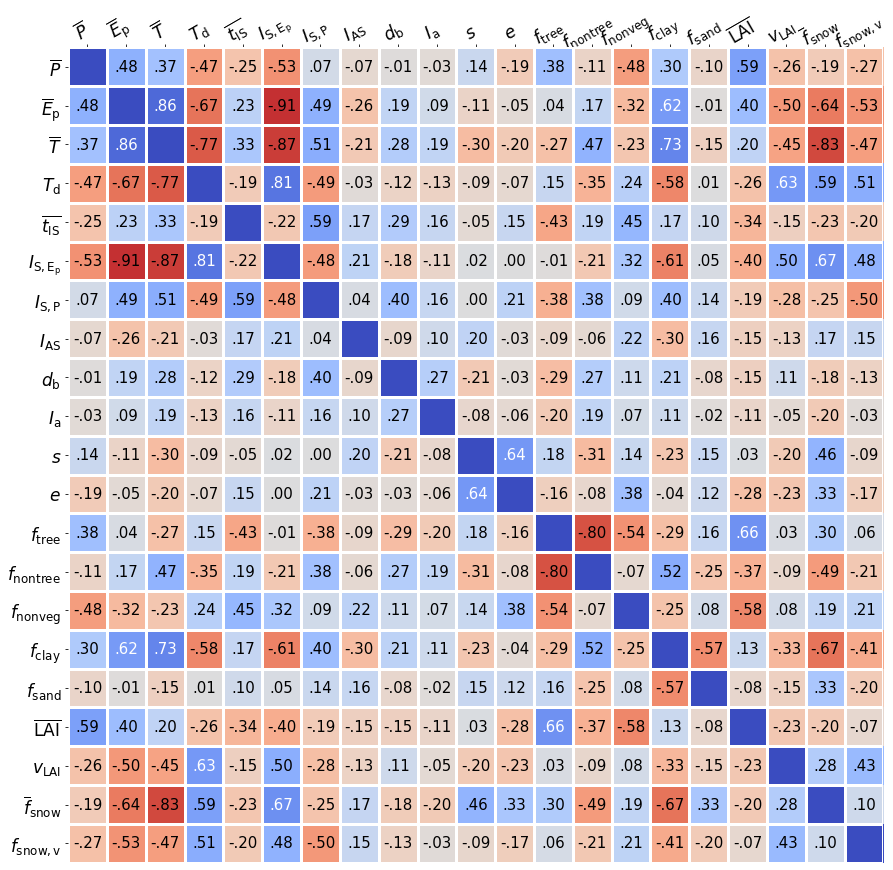

In [9]:
f = f'{work_dir}/master_characteristics_gswp-p_gleam-ep_gswp-t_v3.csv'
df = pd.read_csv(f,index_col=0)
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
df = df[features]
df = df.dropna()
df = df.rename(columns={'idu_mean':'$\overline{t_\mathrm{IS}}$','tdiff_mean':'$T_{\mathrm{d}}$','t_mean':'$\overline{T}$', 'asi':'$I_{\mathrm{AS}}$','p_mean':'$\overline{P}$','si_p':'$I_{\mathrm{S,P}}$','ep_mean':'$\overline{E}_\mathrm{p}$',
                    'sc_mean':'$\overline{f}_{\mathrm{snow}}$','pclay':'$f_{\mathrm{clay}}$','slp_mean':'$s$','lai_mean':'$\overline{\mathrm{LAI}}$','ntc':'$f_{\mathrm{nontree}}$','dtb':'$d_{\mathrm{b}}$','si_ep':'$I_{\mathrm{S,E_p}}$',
                        'lai_rsd':'$v_\mathrm{LAI}$','nonveg':'$f_{\mathrm{nonveg}}$','el_mean':'$e$','psand':'$f_{\mathrm{sand}}$','sc_rsd':'$f_{\mathrm{snow,v}}$','tc':'$f_{\mathrm{tree}}$','ia':'$I_\mathrm{a}$'})
xl = df.columns
yl = df.columns

corr = df.corr()
fig, ax = plt.subplots(1,1,figsize=(15,15))
im = heatmap(corr, xl,yl, ax=ax,
                cmap="coolwarm_r", vmin=-1, vmax=1)

def func(x, pos):
    return f"{x:.2f}".replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func),threshold=0.6, size=15)
plt.show()
fig.savefig(f'{fig_dir}/corrmatrix_21variables.jpg',bbox_inches='tight',dpi=600)

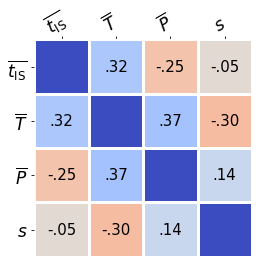

In [10]:
f = f'{work_dir}/master_characteristics_gswp-p_gleam-ep_gswp-t_v3.csv'
df = pd.read_csv(f,index_col=0)
features = ['idu_mean', 't_mean','p_mean','slp_mean']
df = df[features]
df = df.dropna()
df = df.rename(columns={'idu_mean':'$\overline{t_\mathrm{IS}}$','t_mean':'$\overline{T}$','p_mean':'$\overline{P}$', 'slp_mean':'$s$'})

xl = df.columns
yl = df.columns

corr = df.corr()
fig, ax = plt.subplots(1,1,figsize=(4,4))
im = heatmap(corr, xl,yl, ax=ax,
                cmap="coolwarm_r", vmin=-1, vmax=1)

def func(x, pos):
    return f"{x:.2f}".replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func),threshold=0.6, size=15)
plt.show()
fig.savefig(f'{fig_dir}/corrmatrix_4variables.jpg',bbox_inches='tight',dpi=600)

# 21-variable model (model A)

In [11]:
mod = 'modela'

In [12]:
#Europe
lat_min_e, lat_max_e = 35,72 # 36,46 only spain cluster
lon_min_e, lon_max_e = -12,29 # -10,5 only spain cluster

#Asia
lat_min_a, lat_max_a = 8,26
lon_min_a, lon_max_a = 68,105

#us
lat_min_u, lat_max_u = 22,62
lon_min_u, lon_max_u = -132,-55

#south america
lat_min_s, lat_max_s = -32,-4
lon_min_s, lon_max_s = -60,-32

#south africa
lat_min_f, lat_max_f = -36,-17
lon_min_f, lon_max_f = 12,36

#australia
lat_min_t, lat_max_t = -40,-25
lon_min_t, lon_max_t = 140,155

### cross validation

In [13]:
max_depth=None
min_samples_leaf=1

In [14]:
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df['catch_id'] = df.index
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_rsd','sc_mean']
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 5 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','train_r2','test_r2','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)
    train_r2 = np.round(r2_score(y, train_y_pred),2)
    
    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    # perm_importance = permutation_importance(rf, X_train, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    # save scores in dataframe
    # sdf.loc[i][['n_estimators','max_depth','min_samples_leaf','max_features']] = [n_estimators,max_depth,min_samples_leaf,max_features]
    sdf.loc[i]['fold'] = i
    sdf.loc[i][['train_mae','train_r2_adj','train_r2']] = [train_mae,train_r2_adj,train_r2]
    sdf.loc[i][['test_mae','test_r2_adj','test_r2']] = [test_mae,test_r2_adj,test_r2]
    sdf.loc[i][['n_train','n_test']] = [n_train,n_test]
    print(i)

    i+=1

0
1
2
3
4


In [15]:
sdf

,n_estimators,max_depth,min_samples_leaf,max_features,train_mae,train_r2_adj,test_mae,test_r2_adj,train_r2,test_r2,n_train,n_test,fold
0,NaN,NaN,NaN,NaN,13.23,0.97,34.13,0.85,0.97,0.85,2889,723,0
1,NaN,NaN,NaN,NaN,12.86,0.98,36.97,0.76,0.98,0.76,2889,723,1
2,NaN,NaN,NaN,NaN,12.99,0.98,36.22,0.79,0.98,0.8,2890,722,2
3,NaN,NaN,NaN,NaN,13.01,0.98,35.99,0.79,0.98,0.8,2890,722,3
4,NaN,NaN,NaN,NaN,13.34,0.97,32.9,0.84,0.97,0.84,2890,722,4


In [16]:
# r squared
r2_train_mean = (sdf.train_r2.mean(axis=0))
r2_train_std = (sdf.train_r2.std(axis=0))
r2_test_mean = (sdf.test_r2.mean(axis=0))
r2_test_std = (sdf.test_r2.std(axis=0))
print(r2_train_mean, r2_train_std)
print(r2_test_mean, r2_test_std)

0.976 0.005477225575051666
0.8099999999999999 0.03605551275463987


In [17]:
#adjusted r squared
r2_train_mean = (sdf.train_r2_adj.mean(axis=0))
r2_train_std = (sdf.train_r2_adj.std(axis=0))
r2_test_mean = (sdf.test_r2_adj.mean(axis=0))
r2_test_std = (sdf.test_r2_adj.std(axis=0))
print(r2_train_mean, r2_train_std)
print(r2_test_mean, r2_test_std)

0.976 0.005477225575051666
0.806 0.03781534080237805


In [18]:
mae_train_mean = (sdf.train_mae.mean(axis=0))
mae_train_std = (sdf.train_mae.std(axis=0))
mae_test_mean = (sdf.test_mae.mean(axis=0))
mae_test_std = (sdf.test_mae.std(axis=0))
print(mae_train_mean, mae_train_std)
print(mae_test_mean, mae_test_std)

13.085999999999999 0.19449935732541657
35.242000000000004 1.6750731327318218


In [19]:
# permutation importances for each cv fold
ddd = pd.DataFrame(index=ddl[0].index, columns=['pi0','pi1','pi2','pi3'])
ddd.pi0 = ddl[0].pi
ddd.pi1 = ddl[1].pi
ddd.pi2 = ddl[2].pi
ddd.pi3 = ddl[3].pi
ddd['mean'] = ddd.mean(axis=1)
ddd['std'] = ddd[['pi0','pi1','pi2','pi3']].std(axis=1)
ddd = ddd.sort_values(by='mean',ascending=False)
ddd['features2'] = ['$\overline{t_\mathrm{IS}}$','$\overline{f}_{\mathrm{snow}}$','$\overline{T}$','$\overline{P}$','$s$','$I_{\mathrm{S,P}}$','$e$','$d_{\mathrm{b}}$',
                    '$f_{\mathrm{snow,v}}$','$\overline{\mathrm{LAI}}$','$I_{\mathrm{AS}}$','$f_{\mathrm{tree}}$','$f_{\mathrm{clay}}$','$f_{\mathrm{nonveg}}$','$\overline{E}_\mathrm{p}$',
                    '$I_{\mathrm{S,E_p}}$','$v_\mathrm{LAI}$','$f_{\mathrm{nontree}}$','$T_{\mathrm{d}}$','$I_\mathrm{a}$','$f_{\mathrm{sand}}$']
rb = cm.get_cmap('terrain', 10)
c1,c2,c3 = rb(1),rb(3),rb(6)
ddd['colors'] = [c1,c1,c1,c1,c3,c1,c3,c3,
                 c1,c2,c1,c2,c3,c2,c1,
                 c1,c2,c2,c1,c2,c3]
ddd

,pi0,pi1,pi2,pi3,mean,std,features2,colors
idu_mean,29.759131,26.158797,23.909003,22.487083,25.578503,3.170620,$\overline{t_\mathrm{IS}}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
sc_mean,11.430888,10.824936,12.504020,21.081881,13.960431,4.798128,$\overline{f}_{\mathrm{snow}}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
t_mean,17.432167,15.527999,15.504694,4.488599,13.238365,5.902685,$\overline{T}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
p_mean,6.089784,7.092321,5.353162,7.533897,6.517291,0.983549,$\overline{P}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
slp_mean,5.516772,4.512212,5.065547,4.898612,4.998286,0.416155,$s$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
si_p,5.429581,3.126231,4.250216,4.059800,4.216457,0.946211,"$I_{\mathrm{S,P}}$","(0.05185185185185184, 0.4962962962962963, 0.89..."
el_mean,3.676832,3.602922,3.837161,5.611735,4.182162,0.958050,$e$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
lai_mean,2.042094,1.848390,1.667020,1.702804,1.815077,0.170463,$d_{\mathrm{b}}$,"(0.6666666666666667, 0.5733333333333334, 0.420..."
dtb,1.463223,2.122875,1.321068,2.326160,1.808331,0.491124,"$f_{\mathrm{snow,v}}$","(0.05185185185185184, 0.4962962962962963, 0.89..."
sc_rsd,1.586831,1.444871,2.085483,2.028366,1.786388,0.318574,$\overline{\mathrm{LAI}}$,"(0.3333333333333333, 0.8666666666666667, 0.466..."


In [20]:
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']

In [21]:
sr_rp = 'sr_20'
df['catch_id'] = df.index
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

train_ix = cv_train_ix[0]
test_ix = cv_test_ix[0]

# X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.3, random_state=42)
X_train = dfx[train_ix]
y_train = dfy[train_ix]
X_test = dfx[test_ix]
y_test = dfy[test_ix]

# save lat lon columns
lat_train = X_train[:,-3]
lon_train = X_train[:,-2]
lat_test = X_test[:,-3]
lon_test = X_test[:,-2]
catch_id_train = X_train[:,-1]
catch_id_test = X_test[:,-1]
# remove lat lon columns
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)

rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
rf = rf.fit(X_train, y_train)
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)

df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_train['lat'] = lat_train
df_train['lon'] = lon_train
df_train['Sr_m'] = y_train
df_train['Sr_p'] = train_y_pred
df_train['Sr_p-Sr_m'] = train_y_pred - y_train
df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_test['lat'] = lat_test
df_test['lon'] = lon_test
df_test['Sr_m'] = y_test
df_test['Sr_p'] = test_y_pred
df_test['Sr_p-Sr_m'] = test_y_pred - y_test
df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred

train_mse = int(mean_squared_error(y_train, train_y_pred))
train_mae = int(np.round(mean_absolute_error(y_train, train_y_pred),0))
train_r2 = np.round(r2_score(y_train, train_y_pred),2)
train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
train_rmse = int(rmse(y_train,train_y_pred))
train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

test_mse = int(mean_squared_error(y_test, test_y_pred))
test_mae = int(np.round(mean_absolute_error(y_test, test_y_pred),0))
test_r2 = np.round(r2_score(y_test, test_y_pred),2)
test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
test_rmse = int(rmse(y_test,test_y_pred))
test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)

n_test = len(y_test)
n_train = len(y_train)

perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
dd = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
dd['pi_mean'] = pi
dd['pi_std'] = perm_importance.importances_std
dd = dd.sort_values(by='pi_mean') 

perm_importance = permutation_importance(rf, X_train, y_train,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
ddtr = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
ddtr['pi_mean'] = pi
ddtr['pi_std'] = perm_importance.importances_std
ddtr = ddtr.sort_values(by='pi_mean')    

sdf = pd.DataFrame(index=[0])
sdf[features] = np.round(pi,4)
sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
sdf[['n_train','n_test']] = [n_train,n_test]


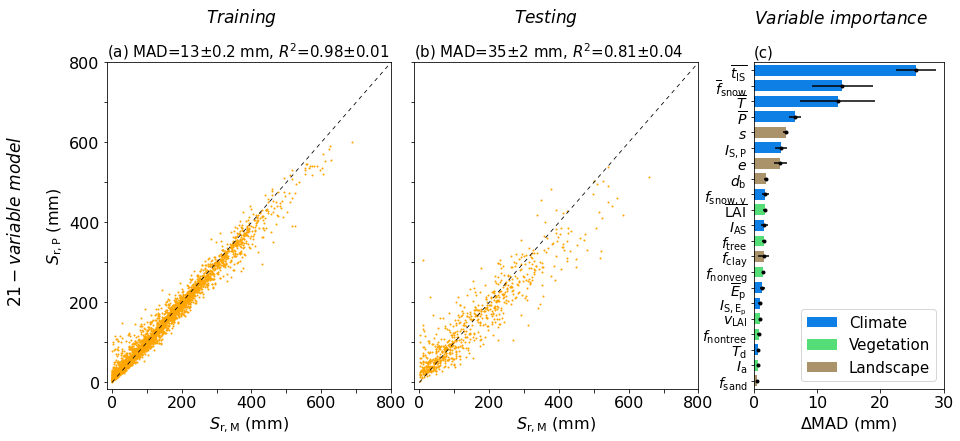

In [22]:
# scatter plots
x = np.linspace(0,800,100)
y = x
cmap_rdbu = cm.get_cmap('bwr_r', 4)
cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix2 = df_train[(df_train['Sr_p-Sr_m']<train_mae)&(df_train['Sr_p-Sr_m']>0)].index
ix1 = df_train[(df_train['Sr_p-Sr_m']>train_mae)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>-train_mae)&(df_train['Sr_p-Sr_m']<0)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae)].index
df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3

df_test['group'] = np.nan
ix2 = df_test[(df_test['Sr_p-Sr_m']<test_mae)&(df_test['Sr_p-Sr_m']>0)].index
ix1 = df_test[(df_test['Sr_p-Sr_m']>test_mae)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>-test_mae)&(df_test['Sr_p-Sr_m']<0)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae)].index
df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3

fig1, ax = plt.subplots(1,4, figsize=(15,6),gridspec_kw={'width_ratios': [3,3,0.1,2]})
ax[2].axis('off')
plt.subplots_adjust(wspace=0.12)
s=ax[0].scatter(df_train.Sr_m,df_train.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[0].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[0].set_xlim(-15,800)
ax[0].set_ylim(-15,800)
ax[0].set_yticks([0,100,200,300,400,500,600,700,800])
ax[0].set_xticks([0,100,200,300,400,500,600,700,800])
ax[0].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xlabel('$S_\mathrm{r,M}$ (mm)',size=16)
ax[0].set_ylabel('$S_\mathrm{r,P}$ (mm)',size=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_title(f'(a) MAD={int(mae_train_mean)}$\pm${np.round(mae_train_std,1)} mm, $R^2$={np.round(r2_train_mean,2)}$\pm${np.round(r2_train_std,2)}', loc='left',size=15)
ax[0].text(270,900,'$\it{Training}$',size=17)
ax[0].text(-300,200,'$\it{21-variable}$ $\it{model}$',size=17,rotation=90)

s=ax[1].scatter(df_test.Sr_m,df_test.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[1].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[1].set_xlim(-15,800)
ax[1].set_ylim(-15,800)
ax[1].set_yticks([0,100,200,300,400,500,600,700,800])
ax[1].set_xticks([0,100,200,300,400,500,600,700,800])
ax[1].set_yticklabels(['','','','','','','','',''])
ax[1].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xlabel('$S_\mathrm{r,M}$ (mm)',size=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_title(f'(b) MAD={int(mae_test_mean)}$\pm${int(np.round(mae_test_std,0))} mm, $R^2$={np.round(r2_test_mean,2)}$\pm${np.round(r2_test_std,2)}', loc='left',size=15)
ax[1].text(270,900,'$\it{Testing}$',size=17)

# feature importances
ddd = ddd.sort_values(by='mean')
ax[3].barh(ddd.features2,ddd['mean'],height=0.7,color=ddd.colors)
ax[3].barh(0,-5,height=0.7,color=ddd.colors[2],label='Climate')
ax[3].barh(0,-5,height=0.7,color=ddd.colors[1],label='Vegetation')
ax[3].barh(0,-5,height=0.7,color=ddd.colors[0],label='Landscape')
ax[3].errorbar(ddd['mean'],ddd.features2, xerr=ddd['std'], fmt=".", color="black")
ax[3].set_xlabel('$\Delta$MAD (mm)',size=16)
ax[3].tick_params(axis='x', labelsize=16)
ax[3].tick_params(axis='y', labelsize=14)
ax[3].set_ylim(-0.5,20.5)
ax[3].set_xlim(0,30)
ax[3].set_title('(c)', loc='left',size=15)
ax[3].legend(loc='lower right',fontsize=15)
ax[3].text(0,23,'$\it{Variable}$ $\it{importance}$',size=17)

fig1.savefig(f'{fig_dir}/scatter_{mod}.jpg',bbox_inches='tight',dpi=300)


# 4 variable model (model B)

In [23]:
mod = 'modelb'

In [24]:
#Europe
lat_min_e, lat_max_e = 35,75 # 36,46 only spain cluster
lon_min_e, lon_max_e = -12,29 # -10,5 only spain cluster

#Asia
lat_min_a, lat_max_a = 1,26
lon_min_a, lon_max_a = 68,105

#us
lat_min_u, lat_max_u = 12,65
lon_min_u, lon_max_u = -132,-52

#south america
lat_min_s, lat_max_s = -31,-3
lon_min_s, lon_max_s = -60,-32

#south africa
lat_min_f, lat_max_f = -35.3,-19.3
lon_min_f, lon_max_f = 12,36

#australia
lat_min_t, lat_max_t = -40,-25
lon_min_t, lon_max_t = 140,155

In [25]:
min_samples_leaf=1
max_depth=None

### cross validation

In [26]:
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df['catch_id'] = df.index
features = ['idu_mean','t_mean','p_mean','slp_mean']
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']

f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 5 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','train_r2','test_r2','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)
    train_r2 = np.round(r2_score(y, train_y_pred),2)
    
    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    # save scores in dataframe
    # sdf.loc[i][['n_estimators','max_depth','min_samples_leaf','max_features']] = [n_estimators,max_depth,min_samples_leaf,max_features]
    sdf.loc[i]['fold'] = i
    sdf.loc[i][['train_mae','train_r2_adj','train_r2']] = [train_mae,train_r2_adj,train_r2]
    sdf.loc[i][['test_mae','test_r2_adj','test_r2']] = [test_mae,test_r2_adj,test_r2]
    sdf.loc[i][['n_train','n_test']] = [n_train,n_test]
    print(i)
    i+=1

0
1
2
3
4


In [27]:
sdf

,n_estimators,max_depth,min_samples_leaf,max_features,train_mae,train_r2_adj,test_mae,test_r2_adj,train_r2,test_r2,n_train,n_test,fold
0,NaN,NaN,NaN,NaN,14.74,0.97,37.56,0.81,0.97,0.81,2889,723,0
1,NaN,NaN,NaN,NaN,14.34,0.97,41.35,0.72,0.97,0.72,2889,723,1
2,NaN,NaN,NaN,NaN,14.46,0.97,39.12,0.78,0.97,0.78,2890,722,2
3,NaN,NaN,NaN,NaN,14.62,0.97,38.65,0.78,0.97,0.78,2890,722,3
4,NaN,NaN,NaN,NaN,14.79,0.97,36.48,0.82,0.97,0.82,2890,722,4


In [28]:
# r squared
r2_train_mean = (sdf.train_r2.mean(axis=0))
r2_train_std = (sdf.train_r2.std(axis=0))
r2_test_mean = (sdf.test_r2.mean(axis=0))
r2_test_std = (sdf.test_r2.std(axis=0))
print(r2_train_mean, r2_train_std)
print(r2_test_mean, r2_test_std)

0.97 0.0
0.7819999999999999 0.03898717737923586


In [29]:
#adjusted r squared
r2_train_mean = (sdf.train_r2_adj.mean(axis=0))
r2_train_std = (sdf.train_r2_adj.std(axis=0))
r2_test_mean = (sdf.test_r2_adj.mean(axis=0))
r2_test_std = (sdf.test_r2_adj.std(axis=0))
print(r2_train_mean, r2_train_std)
print(r2_test_mean, r2_test_std)

0.97 0.0
0.7819999999999999 0.03898717737923586


In [30]:
mae_train_mean = (sdf.train_mae.mean(axis=0))
mae_train_std = (sdf.train_mae.std(axis=0))
mae_test_mean = (sdf.test_mae.mean(axis=0))
mae_test_std = (sdf.test_mae.std(axis=0))
print(mae_train_mean, mae_train_std)
print(mae_test_mean, mae_test_std)

14.589999999999998 0.18894443627691154
38.632 1.8307293628496824


In [31]:
# permutation importances for each cv fold
ddd = pd.DataFrame(index=ddl[0].index, columns=['pi0','pi1','pi2','pi3'])
ddd.pi0 = ddl[0].pi
ddd.pi1 = ddl[1].pi
ddd.pi2 = ddl[2].pi
ddd.pi3 = ddl[3].pi
ddd['mean'] = ddd.mean(axis=1)
ddd['std'] = ddd[['pi0','pi1','pi2','pi3']].std(axis=1)
ddd = ddd.sort_values(by='mean',ascending=False)
ddd['features2'] = ['$\overline{t_\mathrm{IS}}$','$\overline{T}$','$\overline{P}$','$s$']
rb = cm.get_cmap('terrain', 10)
c1,c2,c3 = rb(1),rb(3),rb(6)
ddd['colors'] = [c1,c1,c1,c3]
ddd

,pi0,pi1,pi2,pi3,mean,std,features2,colors
idu_mean,42.258868,45.257323,37.891021,43.581258,42.247118,3.152617,$\overline{t_\mathrm{IS}}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
t_mean,39.210363,36.121749,36.887359,34.647381,36.716713,1.904690,$\overline{T}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
p_mean,15.036016,17.945030,14.559422,20.617110,17.039395,2.815671,$\overline{P}$,"(0.05185185185185184, 0.4962962962962963, 0.89..."
slp_mean,16.213116,13.220095,14.314581,13.458328,14.301530,1.358286,$s$,"(0.6666666666666667, 0.5733333333333334, 0.420..."


In [32]:
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['idu_mean','t_mean','p_mean','slp_mean']

In [33]:
sr_rp = 'sr_20'
df['catch_id'] = df.index
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

train_ix = cv_train_ix[1]
test_ix = cv_test_ix[1]

X_train = dfx[train_ix]
y_train = dfy[train_ix]
X_test = dfx[test_ix]
y_test = dfy[test_ix]

# save lat lon columns
lat_train = X_train[:,-3]
lon_train = X_train[:,-2]
lat_test = X_test[:,-3]
lon_test = X_test[:,-2]
catch_id_train = X_train[:,-1]
catch_id_test = X_test[:,-1]
# remove lat lon columns
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)

rf = RandomForestRegressor(criterion='absolute_error',random_state=42,max_depth=max_depth,min_samples_leaf=min_samples_leaf,oob_score=True)
rf = rf.fit(X_train, y_train)
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)
individual_tree_predictions = np.array([tree.predict(X_test) for tree in rf.estimators_]).T
std_test = np.std(individual_tree_predictions,axis=1)
individual_tree_predictions = np.array([tree.predict(X_train) for tree in rf.estimators_]).T
std_train = np.std(individual_tree_predictions,axis=1)

df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m','std_train'])
df_train['lat'] = lat_train
df_train['lon'] = lon_train
df_train['Sr_m'] = y_train
df_train['Sr_p'] = train_y_pred
df_train['Sr_p-Sr_m'] = train_y_pred - y_train
df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred
df_train['std'] = std_train

df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m','std_test'])
df_test['lat'] = lat_test
df_test['lon'] = lon_test
df_test['Sr_m'] = y_test
df_test['Sr_p'] = test_y_pred
df_test['Sr_p-Sr_m'] = test_y_pred - y_test
df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
df_test['std'] = std_test

train_mse = int(mean_squared_error(y_train, train_y_pred))
train_mae = int(np.round(mean_absolute_error(y_train, train_y_pred),0))
train_r2 = np.round(r2_score(y_train, train_y_pred),2)
train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
train_rmse = int(rmse(y_train,train_y_pred))
train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

test_mse = int(mean_squared_error(y_test, test_y_pred))
test_mae = int(np.round(mean_absolute_error(y_test, test_y_pred),0))
test_r2 = np.round(r2_score(y_test, test_y_pred),2)
test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
test_rmse = int(rmse(y_test,test_y_pred))
test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)

n_test = len(y_test)
n_train = len(y_train)

perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
dd = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
dd['pi_mean'] = pi
dd['pi_std'] = perm_importance.importances_std
dd = dd.sort_values(by='pi_mean') 

perm_importance = permutation_importance(rf, X_train, y_train,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
ddtr = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
ddtr['pi_mean'] = pi
ddtr['pi_std'] = perm_importance.importances_std
ddtr = ddtr.sort_values(by='pi_mean')    

sdf = pd.DataFrame(index=[0])
sdf[features] = np.round(pi,4)
sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
sdf[['n_train','n_test']] = [n_train,n_test]


In [34]:
df_test

,lat,lon,Sr_m,Sr_p,Sr_p-Sr_m,(Sr_p-Sr_m)/Sr_m,std_test,std
br_0001191,-13.3646,-39.0813,173.824040,173.211761,-0.612279,-0.003535,NaN,83.321696
ca_0005679,49.0937,-120.6729,108.511781,91.474556,-17.037225,-0.186251,NaN,70.325167
us_0002162,32.9771,-85.7396,186.107329,191.912494,5.805165,0.030249,NaN,31.306571
fr_0000453,45.2646,1.3771,130.998251,129.571450,-1.426801,-0.011012,NaN,75.012951
ca_0004570,51.1396,-120.1187,26.879852,39.119919,12.240068,0.312886,NaN,37.678715
...,...,...,...,...,...,...,...,...
3182500,38.18595,-80.13062,38.715440,53.631051,14.915611,0.278115,NaN,31.814185
8101000,31.28489,-97.88502,325.049120,318.160812,-6.888308,-0.021650,NaN,51.618160
7180500,38.19645,-96.82458,202.793262,225.190313,22.397052,0.099458,NaN,82.616599
9497980,33.82783,-110.85623,213.232311,197.104875,-16.127436,-0.081822,NaN,68.042517


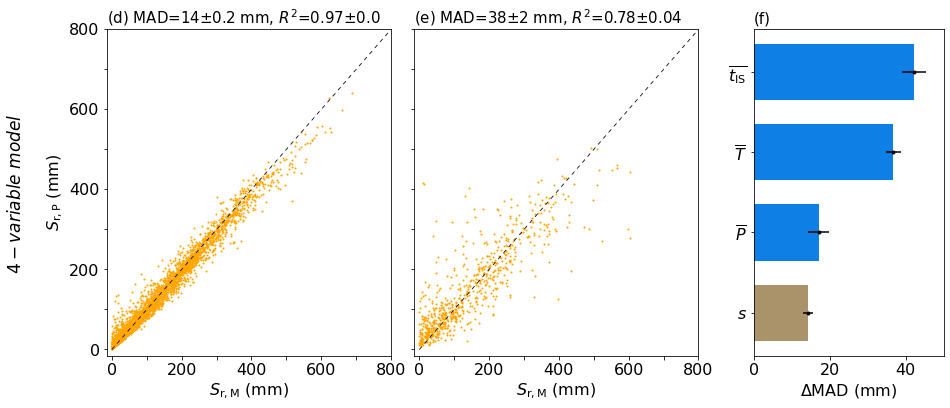

In [35]:
# scatter plots
x = np.linspace(0,800,100)
y = x
cmap_rdbu = cm.get_cmap('bwr_r', 4)
cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])

bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix2 = df_train[(df_train['Sr_p-Sr_m']<train_mae)&(df_train['Sr_p-Sr_m']>0)].index
ix1 = df_train[(df_train['Sr_p-Sr_m']>train_mae)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>-train_mae)&(df_train['Sr_p-Sr_m']<0)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae)].index
df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3

df_test['group'] = np.nan
ix2 = df_test[(df_test['Sr_p-Sr_m']<test_mae)&(df_test['Sr_p-Sr_m']>0)].index
ix1 = df_test[(df_test['Sr_p-Sr_m']>test_mae)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>-test_mae)&(df_test['Sr_p-Sr_m']<0)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae)].index
df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3

fig1, ax = plt.subplots(1,4, figsize=(15,6),gridspec_kw={'width_ratios': [3,3,0.1,2]})
ax[2].axis('off')
plt.subplots_adjust(wspace=0.12)
s=ax[0].scatter(df_train.Sr_m,df_train.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[0].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[0].set_xlim(-15,800)
ax[0].set_ylim(-15,800)
ax[0].set_yticks([0,100,200,300,400,500,600,700,800])
ax[0].set_xticks([0,100,200,300,400,500,600,700,800])
ax[0].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xlabel('$S_\mathrm{r,M}$ (mm)',size=16)
ax[0].set_ylabel('$S_\mathrm{r,P}$ (mm)',size=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_title(f'(d) MAD={int(mae_train_mean)}$\pm${np.round(mae_train_std,1)} mm, $R^2$={np.round(r2_train_mean,2)}$\pm${np.round(r2_train_std,2)}', loc='left',size=15)
ax[0].text(-300,200,'$\it{4-variable}$ $\it{model}$',size=17,rotation=90)

s=ax[1].scatter(df_test.Sr_m,df_test.Sr_p,c='orange',s=1,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[1].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[1].set_xlim(-15,800)
ax[1].set_ylim(-15,800)
ax[1].set_yticks([0,100,200,300,400,500,600,700,800])
ax[1].set_xticks([0,100,200,300,400,500,600,700,800])
ax[1].set_yticklabels(['','','','','','','','',''])
ax[1].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xlabel('$S_\mathrm{r,M}$ (mm)',size=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_title(f'(e) MAD={int(mae_test_mean)}$\pm${int(np.round(mae_test_std,0))} mm, $R^2$={np.round(r2_test_mean,2)}$\pm${np.round(r2_test_std,2)}', loc='left',size=15)

# feature importances
rb = cm.get_cmap('terrain', 10)
c1,c2,c3 = rb(1),rb(3),rb(6)
ddd = ddd.sort_values(by='mean')
ax[3].barh(ddd.features2,ddd['mean'],height=0.7,color=ddd['colors'])
ax[3].errorbar(ddd['mean'],ddd.features2, xerr=ddd['std'], fmt=".", color="black")
ax[3].set_xlabel('$\Delta$MAD (mm)',size=16)
ax[3].tick_params(axis='x', labelsize=16)
ax[3].tick_params(axis='y', labelsize=16)
# ax[3].set_ylim(-0.5,20.5)
ax[3].set_xlim(0,50)
ax[3].set_title('(f)', loc='left',size=15)
fig1.savefig(f'{fig_dir}/scatter_{mod}.jpg',bbox_inches='tight',dpi=300)


In [36]:
# combine all cv's train and test results
test_dfs=[]
train_dfs=[]
for i in range(5):
    train_ix = cv_train_ix[i]
    test_ix = cv_test_ix[i]

    X_train = dfx[train_ix]
    y_train = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix]

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)
    individual_tree_predictions = np.array([tree.predict(X_test) for tree in rf.estimators_]).T
    std_test = np.std(individual_tree_predictions,axis=1)
    individual_tree_predictions = np.array([tree.predict(X_train) for tree in rf.estimators_]).T
    std_train = np.std(individual_tree_predictions,axis=1)

    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m','std'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y_train
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y_train
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred
    df_train['std'] = std_train
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m','std'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    df_test['std'] = std_test
    test_dfs.append(df_test)

test_dfs = pd.concat(test_dfs)
train_dfs = pd.concat(train_dfs)

# color catchments in scatter plot based on error and use same colors on a map
train_dfs['group'] = np.nan
ix2 = train_dfs[(train_dfs['Sr_p-Sr_m']<mae_train_mean)&(train_dfs['Sr_p-Sr_m']>0)].index
ix1 = train_dfs[(train_dfs['Sr_p-Sr_m']>mae_train_mean)].index
ix3 = train_dfs[(train_dfs['Sr_p-Sr_m']>-mae_train_mean)&(train_dfs['Sr_p-Sr_m']<0)].index
ix4 = train_dfs[(train_dfs['Sr_p-Sr_m']<-mae_train_mean)].index
train_dfs.loc[ix1,'group'] = 0
train_dfs.loc[ix2,'group'] = 1
train_dfs.loc[ix3,'group'] = 2
train_dfs.loc[ix4,'group'] = 3

test_dfs['group'] = np.nan
ix2 = test_dfs[(test_dfs['Sr_p-Sr_m']<mae_test_mean)&(test_dfs['Sr_p-Sr_m']>0)].index
ix1 = test_dfs[(test_dfs['Sr_p-Sr_m']>mae_test_mean)].index
ix3 = test_dfs[(test_dfs['Sr_p-Sr_m']>-mae_test_mean)&(test_dfs['Sr_p-Sr_m']<0)].index
ix4 = test_dfs[(test_dfs['Sr_p-Sr_m']<-mae_test_mean)].index
test_dfs.loc[ix1,'group'] = 0
test_dfs.loc[ix2,'group'] = 1
test_dfs.loc[ix3,'group'] = 2
test_dfs.loc[ix4,'group'] = 3

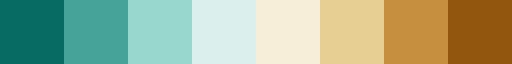

In [37]:
import matplotlib
cmap = cm.get_cmap('BrBG_r', 10)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap_rdbu = ListedColormap(color_list[1:-1])
cmap_rdbu.set_over(color_list[-1])
cmap_rdbu.set_under(color_list[0])
cmap_rdbu

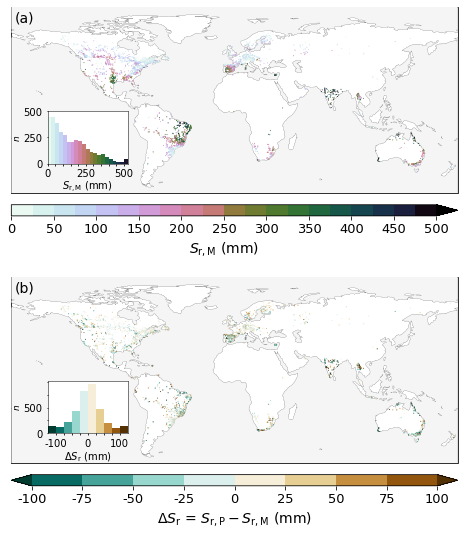

In [38]:
# sr memory method maps
cmap_rdbu1 = cmap_sr
bounds = np.linspace(0,500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

fig2 = plt.figure(figsize=(8,16))
ax = fig2.add_subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=-0.55)

ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.7,c=test_dfs['Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=40,norm=norm)
cbar.set_label('$S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_ticks(bounds2)
cbar.set_ticklabels(['0','50','100','150','200','250','300','350','400','450','500'],size=13)
ax.text(-177,78,'(a)',size=14,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
n=[]
for i in range(len(bounds)):
    if (i<len(bounds)-1):
        nn = len(test_dfs[(test_dfs['Sr_m']<bounds[i+1])&(test_dfs['Sr_m']>=bounds[i])])
    else:
        nn=len(test_dfs[(test_dfs['Sr_m']>=bounds[i])])
    n.append(nn)
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],n,width=1,
        color=[cmap_rdbu1(0),cmap_rdbu1(1),cmap_rdbu1(2),cmap_rdbu1(3),cmap_rdbu1(4),cmap_rdbu1(5),cmap_rdbu1(6),cmap_rdbu1(7),cmap_rdbu1(8),cmap_rdbu1(9),cmap_rdbu1(10),
              cmap_rdbu1(11),cmap_rdbu1(12),cmap_rdbu1(13),cmap_rdbu1(14),cmap_rdbu1(15),cmap_rdbu1(16),cmap_rdbu1(17),cmap_rdbu1(18),cmap_rdbu1(19),cmap_rdbu1(20)])
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','250','','','','','500'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,250,500])
iax.set_yticklabels(['0','250','500'])
iax.set_xlabel('$S_\mathrm{r,M}$ (mm)',size=10,labelpad=1)
iax.set_ylabel('$n$',size=9,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=10)


# all test results from cross validation on map - ABSDIFF
cmap_rdbu1 = cm.get_cmap('BrBG_r',10)
bounds = np.linspace(-100,100,9)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

x=test_dfs['lat'].astype(float)
y=test_dfs['lon'].astype(float)
kde = gaussian_kde(np.vstack([x, y]))
density1 = kde(np.vstack([x, y]))*1000
density2 = (np.clip(density1, 0.06, 0.23))
test_dfs['density'] = 1/(density2*10)

ax = fig2.add_subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.5*test_dfs['density'],c=test_dfs['Sr_p-Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=105)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=40,norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ = $S_\mathrm{r,P}-S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=13)
ax.text(-177,78,'(b)',size=14,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
n0=len(test_dfs[test_dfs['Sr_p-Sr_m']<bounds[0]])
n1=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[1])&(test_dfs['Sr_p-Sr_m']>bounds[0])])
n2=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[2])&(test_dfs['Sr_p-Sr_m']>bounds[1])])
n3=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[3])&(test_dfs['Sr_p-Sr_m']>bounds[2])])
n4=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[4])&(test_dfs['Sr_p-Sr_m']>bounds[3])])
n5=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[5])&(test_dfs['Sr_p-Sr_m']>bounds[4])])
n6=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[6])&(test_dfs['Sr_p-Sr_m']>bounds[5])])
n7=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[7])&(test_dfs['Sr_p-Sr_m']>bounds[6])])
n8=len(test_dfs[(test_dfs['Sr_p-Sr_m']<bounds[8])&(test_dfs['Sr_p-Sr_m']>bounds[7])])
n9=len(test_dfs[(test_dfs['Sr_p-Sr_m']>bounds[8])])
n = [n0,n1,n2,n3,n4,n5,n6,n7,n8,n9]
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar([0,1,2,3,4,5,6,7,8,9],n,width=1,color=[cmap_rdbu1(0),cmap_rdbu1(1),cmap_rdbu1(2),cmap_rdbu1(3),cmap_rdbu1(4),cmap_rdbu1(5),cmap_rdbu1(6),cmap_rdbu1(7),cmap_rdbu1(8),cmap_rdbu1(9)])
iax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])
iax.set_yticks([0,250,500,750,1000])
iax.set_yticklabels(['0','','500','',''])
iax.set_xticklabels(['-100','','','','0','','','','100'])
iax.set_xlim(-0.5,9.5)
iax.set_xlabel('$\Delta$$S_\mathrm{r}$ (mm)',size=10, labelpad=1)
iax.set_ylabel('$n$',size=9,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=10)
fig2.savefig(f'{fig_dir}/fig01.jpg',bbox_inches='tight',dpi=900)


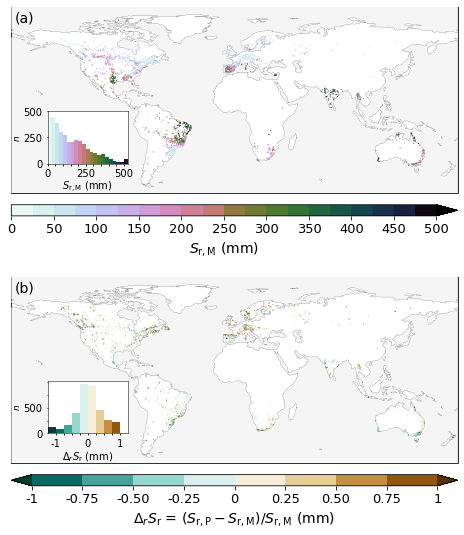

In [39]:
# sr memory method maps
cmap_rdbu1 = cmap_sr
bounds = np.linspace(0,500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

fig2 = plt.figure(figsize=(8,16))
ax = fig2.add_subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=-0.55)

ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.7,c=test_dfs['Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=40,norm=norm)
cbar.set_label('$S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_ticks(bounds2)
cbar.set_ticklabels(['0','50','100','150','200','250','300','350','400','450','500'],size=13)
ax.text(-177,78,'(a)',size=14,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
n=[]
for i in range(len(bounds)):
    if (i<len(bounds)-1):
        nn = len(test_dfs[(test_dfs['Sr_m']<bounds[i+1])&(test_dfs['Sr_m']>=bounds[i])])
    else:
        nn=len(test_dfs[(test_dfs['Sr_m']>=bounds[i])])
    n.append(nn)
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],n,width=1,
        color=[cmap_rdbu1(0),cmap_rdbu1(1),cmap_rdbu1(2),cmap_rdbu1(3),cmap_rdbu1(4),cmap_rdbu1(5),cmap_rdbu1(6),cmap_rdbu1(7),cmap_rdbu1(8),cmap_rdbu1(9),cmap_rdbu1(10),
              cmap_rdbu1(11),cmap_rdbu1(12),cmap_rdbu1(13),cmap_rdbu1(14),cmap_rdbu1(15),cmap_rdbu1(16),cmap_rdbu1(17),cmap_rdbu1(18),cmap_rdbu1(19),cmap_rdbu1(20)])
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','250','','','','','500'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,250,500])
iax.set_yticklabels(['0','250','500'])
iax.set_xlabel('$S_\mathrm{r,M}$ (mm)',size=10,labelpad=1)
iax.set_ylabel('$n$',size=9,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=10)


# all test results from cross validation on map - REL
cmap_rdbu1 = cm.get_cmap('BrBG_r',10)
bounds = np.linspace(-1,1,9)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

x=test_dfs['lat'].astype(float)
y=test_dfs['lon'].astype(float)
kde = gaussian_kde(np.vstack([x, y]))
density1 = kde(np.vstack([x, y]))*1000
density2 = (np.clip(density1, 0.06, 0.23))
test_dfs['density'] = 1/(density2*10)

ax = fig2.add_subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.5*test_dfs['density'],c=test_dfs['(Sr_p-Sr_m)/Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=105)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=40,norm=norm)
cbar.set_label('$\Delta_r$$S_\mathrm{r}$ = ($S_\mathrm{r,P}-S_\mathrm{r,M})/S_\mathrm{r,M}$ (mm)',size=14)
cbar.set_ticklabels(['-1','-0.75','-0.50','-0.25','0','0.25','0.50','0.75','1'],size=13)
ax.text(-177,78,'(b)',size=14,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
n0=len(test_dfs[test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[0]])
n1=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[1])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[0])])
n2=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[2])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[1])])
n3=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[3])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[2])])
n4=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[4])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[3])])
n5=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[5])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[4])])
n6=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[6])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[5])])
n7=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[7])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[6])])
n8=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']<bounds[8])&(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[7])])
n9=len(test_dfs[(test_dfs['(Sr_p-Sr_m)/Sr_m']>bounds[8])])
n = [n0,n1,n2,n3,n4,n5,n6,n7,n8,n9]
n = [n0,n1,n2,n3,n4,n5,n6,n7,n8,n9]
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar([0,1,2,3,4,5,6,7,8,9],n,width=1,color=[cmap_rdbu1(0),cmap_rdbu1(1),cmap_rdbu1(2),cmap_rdbu1(3),cmap_rdbu1(4),cmap_rdbu1(5),cmap_rdbu1(6),cmap_rdbu1(7),cmap_rdbu1(8),cmap_rdbu1(9)])
iax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])
iax.set_yticks([0,250,500,750,1000])
iax.set_yticklabels(['0','','500','',''])
iax.set_xticklabels(['-1','','','','0','','','','1'])
iax.set_xlim(-0.5,9.5)
iax.set_xlabel('$\Delta_r$$S_\mathrm{r}$ (mm)',size=10, labelpad=1)
iax.set_ylabel('$n$',size=9,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=10)

fig2.savefig(f'{fig_dir}/reldiff_maps.jpg',bbox_inches='tight',dpi=900)


In [40]:
a = len(test_dfs[abs(test_dfs['Sr_p-Sr_m']<50)])
print('the number of catchments within +/- 50 mm error:', a)
print('the % of catchments within +/- 50 mm error:', a/len(test_dfs) * 100)

the number of catchments within +/- 50 mm error: 3173
the % of catchments within +/- 50 mm error: 87.84606866002214


## ICE plots - test results 5 cvs

In [41]:
# combine all cv's train and test results
grid_resolution=100
ps = []
ics = []
for i in range(5):
    train_ix = cv_train_ix[i]
    test_ix = cv_test_ix[i]

    X_train = dfx[train_ix]
    y_train = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix]

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y_train
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y_train
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    
    pdps=[]
    ices=[]
    for k in range(len(features)):
        a = partial_dependence(rf, features=[k], X=X_test, percentiles=(0, 1),grid_resolution=grid_resolution, kind='both')
        if(k==0):
            a = partial_dependence(rf, features=[k], X=X_test, percentiles=(0, 1),grid_resolution=1000, kind='both') # higher grid resolution for idu mean
        pdpp = pd.DataFrame(index=['average'],data=a['average'],columns=a['values'][0])
        ice = pd.DataFrame(index=df_test.index, data=a['individual'][0],columns=a['values'][0])
        pdp = pd.concat([pdpp])
        pdps.append(pdp)
        ices.append(ice)
    ps.append(pdps)
    ics.append(ices)

In [42]:
# interpolate so we get same x axis for all cross validation folds
icsi=[]
for k in range(len(features)):
    ice0 = ics[0][k]
    ice1 = ics[1][k]
    ice2 = ics[2][k]
    ice3 = ics[3][k]
    ice4 = ics[4][k]
    
    x0 = ice0.columns.values
    x1 = ice1.columns.values
    x2 = ice2.columns.values
    x3 = ice3.columns.values
    x4 = ice4.columns.values
    
    mi = np.min([ice0.columns.values[0],ice1.columns.values[0],ice2.columns.values[0],ice3.columns.values[0],ice4.columns.values[0]])
    ma = np.max([ice0.columns.values[-1],ice1.columns.values[-1],ice2.columns.values[-1],ice3.columns.values[-1],ice4.columns.values[-1]])
    
    xx = np.linspace(mi,ma,100)
    if (k==0):
        xx = np.linspace(mi,ma,500)
    
    ice0i = pd.DataFrame(index=ice0.index,columns=xx)
    ice1i = pd.DataFrame(index=ice1.index,columns=xx)
    ice2i = pd.DataFrame(index=ice2.index,columns=xx)
    ice3i = pd.DataFrame(index=ice3.index,columns=xx)
    ice4i = pd.DataFrame(index=ice4.index,columns=xx)
    
    for i in ice0.index:
        y0 = ice0.loc[i].values
        y0i = np.interp(xx,x0,y0)
        ice0i.loc[i] = y0i
    for i in ice1.index:
        y1 = ice1.loc[i].values
        y1i = np.interp(xx,x1,y1)
        ice1i.loc[i] = y1i
    for i in ice2.index:
        y2 = ice2.loc[i].values
        y2i = np.interp(xx,x2,y2)
        ice2i.loc[i] = y2i
    for i in ice3.index:
        y3 = ice3.loc[i].values
        y3i = np.interp(xx,x3,y3)
        ice3i.loc[i] = y3i
    for i in ice4.index:
        y4 = ice4.loc[i].values
        y4i = np.interp(xx,x4,y4)
        ice4i.loc[i] = y4i
    icei = pd.concat([ice0i,ice1i,ice2i,ice3i,ice4i])
    icei = icei.astype(float)
    icsi.append(icei)

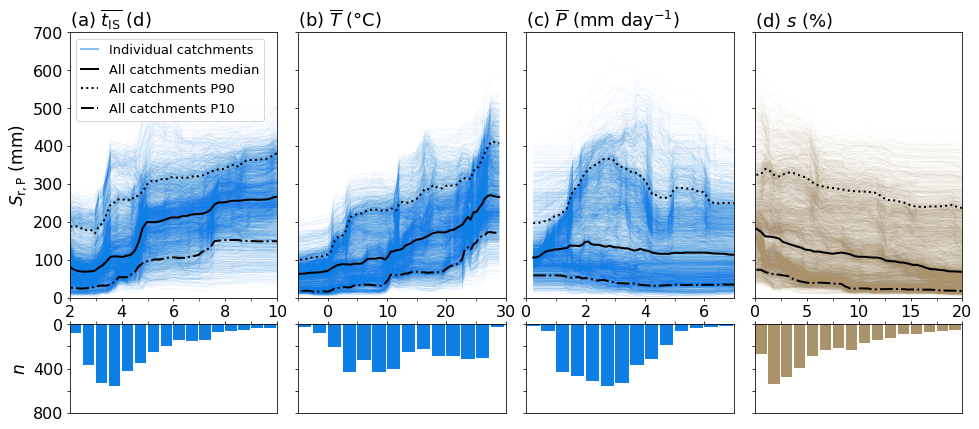

In [43]:
# ices based on 0-1 range, plot limited range - interpolated
var = ['$\overline{t_\mathrm{IS}}$','$\overline{T}$','$\overline{P}$','$s$']
units = ['d','$\degree$C','mm $\mathrm{day}^{-1}$','%']
abcd = ['(a)','(b)','(c)','(d)']

major_t = [0,10,20,30]
minor_t = [-5,5,15,25]
major_idu = [2,4,6,8,10]
minor_idu = [3,5,7,9]
major_p = [0,2,4,6]
minor_p = [1,3,5]
major_slp = [0,5,10,15,20]
minor_slp = [2.5,7.5,12.5,17.5]
majors = [major_idu,major_t,major_p,major_slp]
minors = [minor_idu,minor_t,minor_p,minor_slp]

xlims = [[2,10],[-5,30],[0,7],[0,20]]

binst = np.arange(-10,32.5,2.5)
binsidu = np.arange(2,10.5,0.5)
binsp = np.arange(0,7.5,0.5)
binsslp = np.arange(0,21.25,1.25)
binslist = [binsidu,binst,binsp,binsslp]

# plot pdp TEST ALL CVS COMBINED
X = np.concatenate([X_train,X_test])
ddf = pd.concat([df_train,df_test])
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15,wspace=0.1)
for k in range(len(features)):
    ice0 = icsi[k]
    c = c1#'tab:blue'
    if (k==3):
        c = c3
    for i in ice0.index:
        ax[0,k].plot(ice0.columns.values, ice0.loc[i],color=c,alpha=0.5,linestyle='-',linewidth=0.05)    
    
    ax[0,k].plot(ice0.columns.values, -1*ice0.iloc[0],color=c,alpha=0.5,linestyle='-',linewidth=2,label='Individual catchments')
    ax[0,k].plot(ice0.columns.values, ice0.median(axis=0),color='k',linestyle='-',linewidth=2, label='All catchments median')
    ax[0,k].plot(ice0.columns.values, np.quantile(ice0,0.9,axis=0),color='k',linestyle=':',linewidth=2, label='All catchments P90')
    ax[0,k].plot(ice0.columns.values, np.quantile(ice0,0.1,axis=0),color='k',linestyle='-.',linewidth=2, label='All catchments P10')
    
    ax[0,k].set_title(f'{abcd[k]} {var[k]} ({units[k]})',size=18, loc='left')
    ax[0,0].set_ylabel('$S_\mathrm{r,P}$ (mm)',size=17)
    ax[0,k].set_ylim(0,700)
    ax[0,k].set_xlim(xlims[k])
    ax[0,k].tick_params(axis='both',labelsize=16)
    ax[0,k].tick_params(which='major', length=3)
    ax[0,k].tick_params(which='minor', length=3)
    ax[0,k].set_xticks(ticks=majors[k])
    ax[0,k].set_xticks(ticks=minors[k],minor=True)
    ax[0,k].set_yticks(ticks=[0,100,200,300,400,500,600,700])
    ax[0,k].set_yticklabels(['','','','','','','',''])
    ax[0,0].set_yticklabels(['0','100','200','300','400','500','600','700'])
    ax[0,0].legend(loc='upper left',fontsize=13,handlelength=1.3)
           
    bins = binslist[k]
    ax[1,k].hist(df.loc[:,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c)
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=17)
    ax[1,k].tick_params(axis='both', labelsize=16)
    ax[1,k].set_ylim(800,0)
    ax[1,k].set_yticks([0,200,400,600,800])
    ax[1,k].set_yticklabels(['','','','',''])
    ax[1,0].set_yticklabels(['0','','400','','800'])
    ax[1,k].set_xlim(xlims[k])
    ax[1,k].set_xticks(ticks=majors[k])
    ax[1,k].set_xticks(ticks=minors[k],minor=True)
    ax[1,k].tick_params(which='major', length=3)
    ax[1,k].tick_params(which='minor', length=3)
    
fig3.savefig(f'{fig_dir}/fig04.jpg',bbox_inches='tight',dpi=600)

## MAKE MANUAL SPLITS

In [44]:
c1 = '#FF1F5B'
c4 = '#FFC61E'

In [45]:
# get ices
# p_mean
k = 2
ice_p0 = ics[0][k]
ice_p1 = ics[1][k]
ice_p2 = ics[2][k]
ice_p3 = ics[3][k]
ice_p4 = ics[4][k]

pdp_p0 = ps[0][k]
pdp_p1 = ps[1][k]
pdp_p2 = ps[2][k]
pdp_p3 = ps[3][k]
pdp_p4 = ps[4][k]

## 2 regimes

/home/fvanoorschot/miniconda3/envs/sr_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


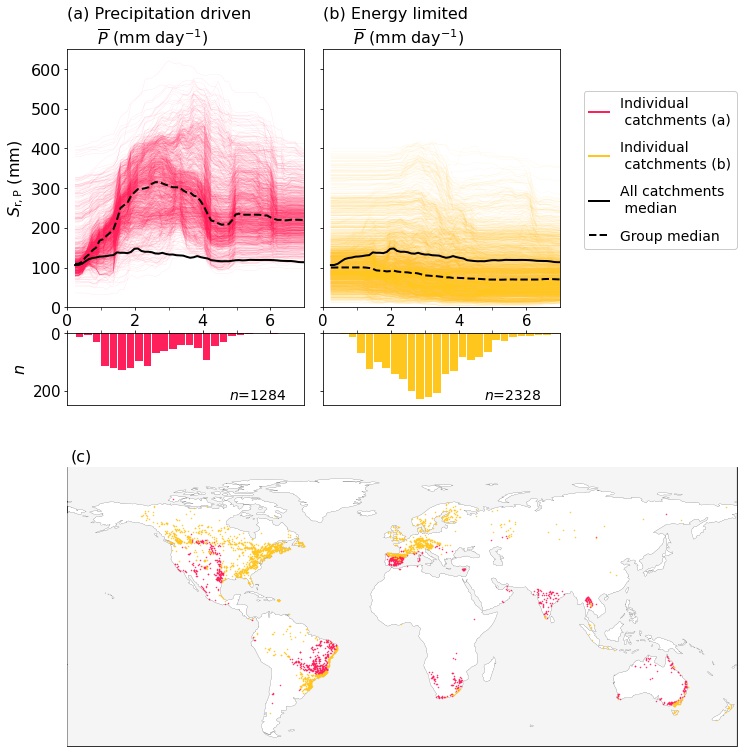

In [46]:
# make plots - ices - pmean - 2 different regimes - interpolated - SLOPE 
var = ['idu_mean','t_mean','p_mean','slp_mean']
var2 = ['$I_\mathrm{ISD}$','$\overline{T}$','$\overline{P}$','$s$']
units = ['d','$\degree$C','mm $\mathrm{day}^{-1}$','%']
major_t = [0,10,20,30]
minor_t = [-5,5,15,25]
major_idu = [2,4,6,8,10]
minor_idu = [3,5,7,9]
major_p = [0,2,4,6]
minor_p = [1,3,5]
major_slp = [0,5,10,15,20]
minor_slp = [2.5,7.5,12.5,17.5]
majors = [major_idu,major_t,major_p,major_slp]
minors = [minor_idu,minor_t,minor_p,minor_slp]

xlims = [[2,10],[-5,30],[0,7],[0,20]]

binst = np.arange(-10,32.5,2.5)
binsidu = np.arange(2,10.5,0.5)
binsp = np.arange(0,7.5,0.25)
binsslp = np.arange(0,21.25,1.25)
binslist = [binsidu,binst,binsp,binsslp]

m=2
k=2
grs1=[]
grs2=[]
grs3=[]
grs4=[]
fig = plt.figure(figsize=(12,15))
gs = fig.add_gridspec(ncols=3, nrows=5,height_ratios=[2.5,1,0.7,0.2,5],width_ratios=[1.5,1.5,1])
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax7 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[2:4, 0])
ax4 = fig.add_subplot(gs[2:4, 1])
ax8 = fig.add_subplot(gs[2:4, 2])
ax6 = fig.add_subplot(gs[4,:],projection=ccrs.PlateCarree())

ax7.axis('off')
ax8.axis('off')

ax1.set_title(f'(a) Precipitation driven \n      {var2[m]} ({units[m]})',size=16, loc='left')
ax1.set_ylabel('$S_\mathrm{r,P}$ (mm)',size=16)
ax1.set_ylim(0,650)
ax1.tick_params(axis='both', labelsize=15)  
ax1.set_xlim(xlims[m])
ax1.tick_params(axis='both',labelsize=16)
ax1.tick_params(which='major', length=3)
ax1.tick_params(which='minor', length=3)
ax1.set_xticks(ticks=majors[k])
ax1.set_xticks(ticks=minors[k],minor=True)
ax1.set_yticks([0,100,200,300,400,500,600])
ax1.set_yticklabels(['','','','','','',''])
ax1.set_yticklabels(['0','100','200','300','400','500','600'])

ax3.set_title(f'(b) Energy limited \n      {var2[m]} ({units[m]})',size=16, loc='left')
ax3.set_ylim(0,650)
ax3.tick_params(axis='both', labelsize=15)  
ax3.set_xlim(xlims[m])
ax3.tick_params(axis='both',labelsize=16)
ax3.tick_params(which='major', length=3)
ax3.tick_params(which='minor', length=3)
ax3.set_xticks(ticks=majors[k])
ax3.set_xticks(ticks=minors[k],minor=True)
ax3.tick_params(axis='both', labelsize=15)
ax3.set_yticks([0,100,200,300,400,500,600])
ax3.set_yticklabels(['','','','','','',''])

ax6.coastlines(linewidth=0.1)
ax6.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax6.set_global()
ax6.set_xlim(-180,180)
ax6.set_ylim(-60,90)
ax6.text(-178,93, f'(c)',zorder=101,size=16)
    
plt.subplots_adjust(wspace=0.09,hspace=-0.2)
ice_p = icsi[m]

# define groups
pos = []
neg = []
slp = (ice_p.iloc[:,-1] - ice_p.iloc[:,0])/(ice_p.columns[-1] - ice_p.columns[0])
for i in ice_p.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
nm = slp.loc[neg].mean()
p1 = slp[slp>pm].index
p2 = slp[slp<pm].index

p = ice_p.index
p1 = []
p2 = []
p3 = []
p4 = []
grr = []
r = []
rr = []
             
for i in p:
    if((ice_p.loc[i].iloc[30] - ice_p.loc[i].iloc[0])/(ice_p.columns[30] - ice_p.columns[0]) < 20):
        p3.append(i)
    else:
        p1.append(i)

gr1 = p1
gr3 = p3
ice = ice_p
ylim = 250
mm = 0
grs1.append(gr1)
grs3.append(gr3)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax1.plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.08,alpha=0.5,zorder=1)
    ax1.plot(ice.columns.values, ice.loc[gr].median(),color='k',linestyle='--',linewidth=2,zorder=2)
    ax1.plot(ice.columns.values, ice.median(),color='k',linestyle='-',linewidth=2,zorder=2)

if (len(gr3)>0):
    gr = gr3
    j = 2
    for i in gr:
        ax3.plot(ice.columns.values, ice.loc[i],color=c4,linestyle='-',linewidth=0.08,alpha=0.5,zorder=1)
    ax3.plot(ice.columns.values, ice.loc[gr].median(),color='k',linestyle='--',linewidth=2,zorder=2)
    ax3.plot(ice.columns.values, ice.median(),color='k',linestyle='-',linewidth=2,zorder=2)

ddf = df.loc[ice.index]
ax6.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5,zorder=102)
ax6.plot(ddf.loc[gr3].lon, ddf.loc[gr3].lat,'o', markeredgecolor=c4, markerfacecolor=c4,markersize=0.5,zorder=102)

bins = binslist[m]

ax2.hist(df.loc[gr1,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c1)
ax2.invert_yaxis()
ax2.xaxis.tick_top()
ax2.axes.get_xaxis().set_ticklabels([])
ax2.set_ylabel('$n$',size=16)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_ylim(ylim,0)
ax2.text(ice.columns.values[-56],ylim-20,f'$n$={len(gr1)}',size=14,zorder=10)
ax2.set_xlim(xlims[m])
ax2.set_xticks(ticks=majors[m])
ax2.set_xticks(ticks=minors[m],minor=True)
ax2.tick_params(which='major', length=3)
ax2.tick_params(which='minor', length=3)

ax4.hist(df.loc[gr3,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]),color=c4)
ax4.invert_yaxis()
ax4.xaxis.tick_top()
ax4.axes.get_xaxis().set_ticklabels([])
ax4.tick_params(axis='both', labelsize=15)
ax4.set_ylim(ylim,0)
ax4.set_yticklabels([])
ax4.text(ice.columns.values[-56],ylim-20,f'$n$={len(gr3)}',size=14,zorder=10)
ax4.set_xlim(xlims[m])
ax4.set_xticks(ticks=majors[m])
ax4.set_xticks(ticks=minors[m],minor=True)
ax4.tick_params(which='major', length=3)
ax4.tick_params(which='minor', length=3)

ax3.plot([-1,-1],[-4,-4],color=c1,linestyle='-',linewidth=2, label='Individual \n catchments (a)')
ax3.plot([-1,-1],[-4,-4],color=c4,linestyle='-',linewidth=2, label='Individual \n catchments (b)')
ax3.plot([-1,-1],[-4,-4],color='k',linestyle='-',linewidth=2, label='All catchments \n median')
ax3.plot([-1,-1],[-4,-4],color='k',linestyle='--',linewidth=2, label='Group median')

legend=ax3.legend(bbox_to_anchor=(1.07, 0.2),fontsize=14,handlelength=1.4,labelspacing=1)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0))
fig.savefig(f'{fig_dir}/fig05.jpg',bbox_inches='tight',dpi=300)

In [47]:
# get other catchment characterstics for regimes
def f(gr):
    d = pd.DataFrame(index=['mean','median','std','q25','q75'], columns=['t_mean','idu_mean','slp_mean','tc','p_mean','sr_20'])
    dd = df.loc[gr]
    d.loc['mean'] = np.round([dd.t_mean.mean(), dd.idu_mean.mean(), dd.slp_mean.mean(), dd.tc.mean(), dd.p_mean.mean(), dd.sr_20.mean()],2)
    d.loc['median'] = np.round([dd.t_mean.median(), dd.idu_mean.median(), dd.slp_mean.median(), dd.tc.median(), dd.p_mean.median(), dd.sr_20.median()],2)
    d.loc['std'] = np.round([dd.t_mean.std(), dd.idu_mean.std(), dd.slp_mean.std(), dd.tc.std(), dd.p_mean.std(), dd.sr_20.std()],2)
    d.loc['q25'] = np.round([dd.t_mean.quantile(0.25), dd.idu_mean.quantile(0.25), dd.slp_mean.quantile(0.25), dd.tc.quantile(0.25), dd.p_mean.quantile(0.25), dd.sr_20.quantile(0.25)],2)
    d.loc['q75'] = np.round([dd.t_mean.quantile(0.75), dd.idu_mean.quantile(0.75), dd.slp_mean.quantile(0.75), dd.tc.quantile(0.75), dd.p_mean.quantile(0.75), dd.sr_20.quantile(0.75)],2)
    return d

In [48]:
f(gr1)

,t_mean,idu_mean,slp_mean,tc,p_mean,sr_20
mean,18.4,7.97,6.45,0.15,2.51,258.12
median,19.48,6.66,4.98,0.13,2.25,243.03
std,6.54,5.56,5.05,0.1,1.22,113.19
q25,13.59,5.56,2.74,0.08,1.55,184.09
q75,23.94,8.24,9.0,0.2,3.36,326.47


In [49]:
f(gr3)

,t_mean,idu_mean,slp_mean,tc,p_mean,sr_20
mean,9.75,3.71,8.1,0.38,3.09,92.65
median,8.52,3.64,5.93,0.39,2.99,71.04
std,7.56,0.86,6.99,0.14,1.24,80.52
q25,4.26,3.11,2.69,0.27,2.26,32.9
q75,14.4,4.23,11.56,0.49,3.76,127.76


## TC CLASSIFICATION

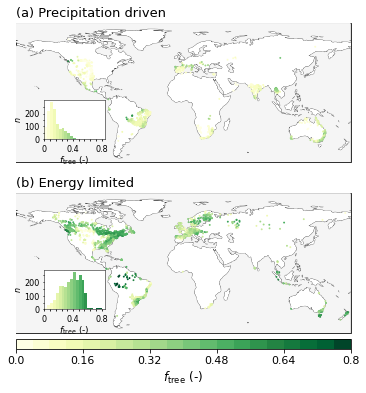

In [50]:
# group by treecover
cmap = ListedColormap([c1,c4])
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['t_mean','idu_mean','p_mean','slp_mean','sr_20','tc']
df1 = df.loc[list(itertools.chain.from_iterable(grs1))] 
df3 = df.loc[list(itertools.chain.from_iterable(grs3))]

bounds = np.linspace(0,0.8,21)
bounds2 = np.linspace(0,0.8,6)

n1 = []
n3 = []
for i in range(len(bounds)):
    if (i<(len(bounds)-1)):
        nn1 = len(df1[(df1.tc<bounds[i+1])&(df1.tc>=bounds[i])])
        n1.append(nn1)
        nn3 = len(df3[(df3.tc<bounds[i+1])&(df3.tc>=bounds[i])])
        n3.append(nn3)
    else:
        nn1 = len(df1[(df1.tc>=bounds[i])])
        n1.append(nn1)
        nn3 = len(df3[(df3.tc>=bounds[i])])
        n3.append(nn3)


cmap_ylgn = cm.get_cmap('YlGn',21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_ylgn.N)

colors=[]
for i in range(len(bounds)):
    colors.append(cmap_ylgn(i)) 


fig = plt.figure(figsize=(6,15))
gs = fig.add_gridspec(ncols=1, nrows=2,height_ratios=[1,0.7])
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, 0],projection=ccrs.PlateCarree())
plt.subplots_adjust(hspace=-0.98)

# RED
ax = ax1
ax.coastlines(linewidth=0.3)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df1.lon,df1.lat,c=df1['tc'],s=0.8,cmap=cmap_ylgn, norm=norm,zorder=101)
ax.set_title('(a) Precipitation driven',size=13,loc='left')

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar(np.arange(0,21,1),n1,width=1,color=colors)
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','0.4','','','','','0.8'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,50,100,150,200,250])
iax.set_yticklabels(['0','','100','','200',''])
iax.set_xlabel('$f_\mathrm{tree}$ (-)',size=9,labelpad=1)
iax.set_ylabel('$n$',size=8,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=8)

# BLUE
ax = ax3
ax.coastlines(linewidth=0.3)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df3.lon,df3.lat,c=df3['tc'],s=0.8,cmap=cmap_ylgn, norm=norm,zorder=101)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal',spacing='proportional',extend='neither',aspect=35, pad=0.01, norm=norm,ticks=bounds2)
cbar.set_ticklabels(bounds2,size=11)
cbar.set_label('$f_\mathrm{tree}$ (-)',size=12)
ax.set_title('(b) Energy limited',size=13,loc='left')

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.07,0.13,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins=bounds
iax.bar(np.arange(0,21,1),n3,width=1,color=colors)
iax.set_xticks(np.arange(-0.5,20,2))
iax.set_xticklabels(['0','','','','','0.4','','','','','0.8'])
iax.set_xlim(-0.5,20.5)
iax.set_yticks([0,50,100,150,200,250])
iax.set_yticklabels(['0','','100','','200',''])
iax.set_xlabel('$f_\mathrm{tree}$ (-)',size=9,labelpad=1)
iax.set_ylabel('$n$',size=8,labelpad=1)
iax.tick_params(axis='both',length=1.5, labelsize=8)
fig.savefig(f'{fig_dir}/fig06.jpg',bbox_inches='tight',dpi=600)

# Global Sr gridded

In [51]:
from global_correlations_final import *

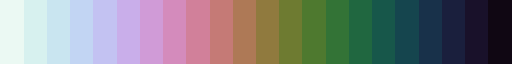

In [52]:
cmap = cm.get_cmap('cubehelix_r', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap_sr = ListedColormap(color_list[1:-1])
cmap_sr.set_over(color_list[-1])
cmap_sr.set_under(color_list[0])
cmap_sr.set_bad('whitesmoke')
cmap_sr

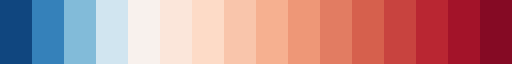

In [53]:
#cmap temperature
cmap = cm.get_cmap('RdBu_r', 26)
cl = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
blues = [cl[1],cl[4],cl[7],cl[10]]
reds = cl[13:25]
cmap_temp = ListedColormap(np.concatenate([blues,reds]))
cmap_temp.set_over(cl[-1])
cmap_temp.set_under(cl[0])
cmap_temp.set_bad('lightgrey')
cmap_temp

## gridded variables

In [54]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()

In [55]:
p = xr.open_dataset(f'{work_dir}/p_mean_gswp3_land.nc')
t = xr.open_dataset(f'{work_dir}/t_mean_gswp3_land.nc')
idu = xr.open_dataset(f'{work_dir}/idu_mean_land.nc')
slp = xr.open_dataset(f'{work_dir}/slp_land.nc')

# change units of slope from degree to percent
rads = np.deg2rad(slp.Band1)
slp_perc = np.tan(rads) * 100
slp['perc'] = slp_perc

In [56]:
# mask out points outside catchment ranges
pmax = df.p_mean.max()
pmin = df.p_mean.min()
pl= xr.where(((p.pr>=pmin)&(p.pr<=pmax)), p.pr, np.nan)

tmax = df.t_mean.max()
tmin = df.t_mean.min()
tl= xr.where(((t.tas>=tmin)&(t.tas<=tmax)), t.tas, np.nan)

idumax = df.idu_mean.max()
idumin = df.idu_mean.min()
idul= xr.where(((idu.idu_mean>=idumin)&(idu.idu_mean<=idumax)), idu.idu_mean, np.nan)

slpmax = df.slp_mean.max()
slpmin = df.slp_mean.min()
slpl= xr.where(((slp.perc>=0)&(slp.perc<=slpmax)), slp.perc, np.nan)

# make one mask
pl = xr.where(((pl>=0)&(idul>=0)&(slpl>=0)&(tl>=-50)),pl,np.nan)
tl = xr.where(((pl>=0)&(idul>=0)&(slpl>=0)&(tl>=-50)),tl,np.nan)
idul = xr.where(((pl>=0)&(idul>=0)&(slpl>=0)&(tl>=-50)),idul,np.nan)
slpl = xr.where(((pl>=0)&(idul>=0)&(slpl>=0)&(tl>=-50)),slp,np.nan)

/tmp/ipykernel_343/3924899522.py:52: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlGnBu").copy()
  cmap.set_bad('whitesmoke')
/tmp/ipykernel_343/3924899522.py:71: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrRd").copy()
  cmap.set_bad('whitesmoke')


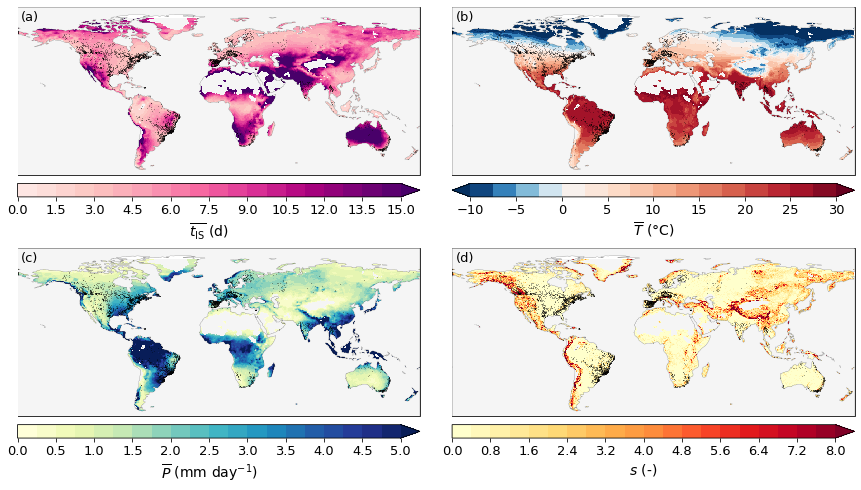

In [57]:
# mask out values outside range
fig2 = plt.figure(figsize=(15,15))
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.08,hspace=-0.58)

# idu mean
lvls = np.linspace(0,15,21)
lvls2 = np.linspace(0,15,11)
cmap = cm.get_cmap('RdPu',23)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap = ListedColormap(color_list[2:])
cmap.set_bad('whitesmoke')
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (idul[:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
cbar.set_label('$\overline{t_\mathrm{IS}}$ (d)',size=14)
cbar.ax.tick_params(axis='x', labelsize=13)
ax.text(-177,78,'(a)',size=13,zorder=101)
ax.set_title('')

# t mean
lvls = np.linspace(-10,30,17)
lvls2 = np.linspace(-10,30,17)
cmap = cmap_temp
cmap.set_bad('whitesmoke')
tl[0,0,0]=-15
tl[0,0,1]=35
ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
# ax.plot(df.lon,df.lat,marker='o',markeredgecolor='k',markerfacecolor=None,markeredgewidth=0.1,markersize=0.5,linestyle='None',zorder=101)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (tl[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls,add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='both', pad=0.015,aspect=30)
cbar.set_label('$\overline{T}$ ($\degree$C)',size=14)
cbar.ax.tick_params(axis='x', labelsize=13)
ax.set_title('')
ax.text(-177,78,'(b)',size=13,zorder=101)

# p mean
lvls = np.linspace(0,5,21)
lvls2 = np.linspace(0,5,11)
cmap = cm.get_cmap('YlGnBu')
cmap.set_bad('whitesmoke')
ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (pl[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal', spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
ax.text(-177,78,'(c)',size=13,zorder=101)
ax.set_title('')
cbar.set_label('$\overline{P}$ ($\mathrm{mm}$ $\mathrm{day}^{-1}$)',size=14)
cbar.ax.tick_params(axis='x', labelsize=13)

# slp mean
lvls = np.linspace(0,8,21)
lvls2 = np.linspace(0,8,11)
cmap = cm.get_cmap('YlOrRd')
cmap.set_bad('whitesmoke')
ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (slpl.perc).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
cbar.set_label('$s$ (-)',size=14)
cbar.ax.tick_params(axis='x', labelsize=13)
ax.text(-177,78,'(d)',size=13,zorder=101)
ax.set_title('')
fig2.savefig(f'{fig_dir}/fig03.jpg',bbox_inches='tight',dpi=600)


## Apply RF to gridded data

In [58]:
min_samples_leaf=1
max_depth=None
data_sources = 'gswp-p_gleam-ep_gswp-t'

In [59]:
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df['catch_id'] = df.index
features = ['idu_mean','t_mean','p_mean','slp_mean']

In [60]:
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 5 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,max_depth=max_depth,min_samples_leaf=min_samples_leaf,oob_score=True)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    i+=1

test_dfs = pd.concat(test_dfs)
train_dfs = pd.concat(train_dfs)

In [61]:
p = xr.open_dataset(f'{work_dir}/p_mean_gswp3_land.nc')
t = xr.open_dataset(f'{work_dir}/t_mean_gswp3_land.nc')
idu = xr.open_dataset(f'{work_dir}/idu_mean_land.nc')
slp = xr.open_dataset(f'{work_dir}/slp_land.nc')

# change units of slope from degree to percent
rads = np.deg2rad(slp.Band1)
slp_perc = np.tan(rads) * 100
slp['perc'] = slp_perc

p_array = p.pr.to_numpy().flatten()
t_array = t.tas.to_numpy().flatten()
idu_array = idu.idu_mean.to_numpy().flatten()
slp_array = slp.Band1.to_numpy().flatten()

lat_array = []
lon_array = []
for m in range(len(p.lat.values)):
    for n in range(len(p.lon.values)):
        lat_array.append(p.lat.values[m])
        lon_array.append(p.lon.values[n])

In [62]:
df = pd.read_csv(f'{work_dir}/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['p_mean','t_mean','idu_mean','slp_mean']

dfs=[]

for i in range(5):
    sr_rp = 'sr_20'
    df['catch_id'] = df.index
    ll = ['lat','lon','catch_id']
    f = features + ll
    dfx = df[f].values
    dfy = df[sr_rp].values
    train_ix = cv_train_ix[i]
    test_ix = cv_test_ix[i]

    X_train = dfx[train_ix]
    y_train = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix]

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    
    dfg = pd.DataFrame(index=np.arange(0,195840,1), columns=['lat','lon','p_mean','t_mean','idu_mean','slp_mean'])
    dfg.loc[:,'lat'] = lat_array
    dfg.loc[:,'lon'] = lon_array
    dfg.loc[:,'p_mean'] = p_array
    dfg.loc[:,'t_mean'] = t_array
    dfg.loc[:,'idu_mean'] = idu_array
    dfg.loc[:,'slp_mean'] = slp_array
    dfg = dfg.dropna()
    
    dfx = dfg[features].values
    test_y_pred = rf.predict(dfx)
    dfg['sr_pred'] = test_y_pred
    dfs.append(dfg)

In [63]:
df0 = dfs[0]
df1 = dfs[1]
df2 = dfs[2]
df3 = dfs[3]
df4 = dfs[4]

In [64]:
dfp = pd.DataFrame(index=np.arange(0,195840,1), columns=['lat','lon','sr_p0','sr_p1','sr_p2','sr_p3','sr_p4'])
dfp.loc[:,'lat'] = lat_array
dfp.loc[:,'lon'] = lon_array
dfp['sr_p0'] = df0['sr_pred']
dfp['sr_p1'] = df1['sr_pred']
dfp['sr_p2'] = df2['sr_pred']
dfp['sr_p3'] = df3['sr_pred']
dfp['sr_p4'] = df4['sr_pred']
dfp['sr_p_mean'] = dfp[['sr_p0','sr_p1','sr_p2','sr_p3','sr_p4']].mean(axis=1)
dfp['sr_p_std'] = dfp[['sr_p0','sr_p1','sr_p2','sr_p3','sr_p4']].std(axis=1)
dfp['sr_p_sm'] = dfp['sr_p_std']/dfp['sr_p_mean']
dfp

,lat,lon,sr_p0,sr_p1,sr_p2,sr_p3,sr_p4,sr_p_mean,sr_p_std,sr_p_sm
0,80.0,-180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,80.0,-179.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80.0,-179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80.0,-178.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80.0,-178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
195835,-55.5,177.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195836,-55.5,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195837,-55.5,178.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195838,-55.5,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# dataframe to 2d xarray
# mean
srp = np.zeros([len(p.lat.values),len(p.lon.values)])
i=0
for n in range(len(p.lat.values)):
    for m in range(len(p.lon.values)):
        srp[n,m] = dfp['sr_p_mean'][i]
        i+=1
lon = p.lon.values
lat = p.lat.values
sr_predicted_map = xr.DataArray(srp,
                       coords={'lat':lat,'lon':lon},
                       dims=['lat','lon'],
                       name='sr_p')

In [66]:
# mask output
sr_predicted_map = sr_predicted_map.where(pl[0,:,:]>=0)
sr_predicted_map.to_netcdf(f'{work_dir}/sr_predicted_map.nc')

Text(0.5, 1.0, 'Root zone storage capacity predicted $S_\\mathrm{r,P}$ (mm)')

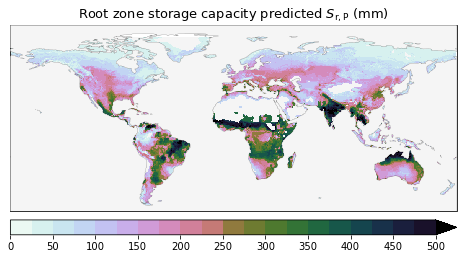

In [67]:
# sr predicted mean
bounds = np.linspace(0, 500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = sr_predicted_map[:,:].plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='',size=10)
ax.set_title('Root zone storage capacity predicted $S_\mathrm{r,P}$ (mm)',size=13)

## REFERENCE ROOT PRODUCTS
The underlying data of the reference root products can be found through the following links:

|     Reference                      |     Variable                                           |     Method   description                                                                                                                                                                                                                                                                          |     Data   reference                                                            |
|------------------------------------|--------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
|     Wang-Erlandsson   (2016)       |     Root   zone storage capacity                       |     Based   on cumulative water deficits, including irrigation. Gumbel-normalized with a   20 years return period                                                                                                                                                                                 |     http://dx.doi.org/10.5194/hess-20-1459-2016-supplement                      |
|     Stocker   et al. (2023)        |     Root   zone storage capacity                       |     Based   on cumulative water deficits. Gumbel-normalised with a 80 year return period                                                                                                                                                                                                          |     https://doi.org/10.5281/zenodo.5515246                                      |
|     Kleidon   et al. (2004)        |     Optimised   hydrologically active rooting depth    |     Estimated   by optimised inverse modelling. Hydrologically active rooting depth is based   on a maximization of net primary production.                                                                                                                                                       |     Upon   request to the author                                                |
|     Fan   et al. (2017)            |     Maximum   depth of root water uptake               |     Inverse   model based on (1) soil water supply based on hydrological model using   observed climate, soil properties and topography; (2) ecosystem water demand   from LAI and reanalysis atmosphere; (3) given (1) and (2) estimate necessary   depths of water uptake to meet the demand    |     https://wci.earth2observe.eu/thredds/catalog/usc/root-depth/catalog.html    |
|     Yang   et al. (2016)           |     Effective   plant rooting depth                    |     Balance   of carbon cost and benefit of root development (Guswa et al., 2008); an   optimal rooting depth at which the marginal carbon benefit associated with   any additional roots balances the marginal carbon cost of those roots                                                        |     http://doi.org/10.4225/08/5837b3aa9cb90                                     |
|     Schenk   et al. (2009)         |     95%   rooting depth                                |     Estimated   rooting depths for 95% of the roots based on observed rooting depths (Schenk   and Jackson, 2003)                                                                                                                                                                                 |     https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=929                         |
|     Schenk   and Jackson (2003)    |     Extrapolated   95% rooting depths                  |     Estimated   from a global database of root profiles assembled from the primary literature   to study relationships of abiotic and biotic factors associated with   belowground vegetation structure.                                                                                          |     https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=660                         |

## all maps normalized

In [68]:
# min and (max-min) for normalization - limit maximum values to 0.99 or 0.95 percentiles
pp = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')
ppp = xr.where(pp.sr_p>pp.sr_p.quantile(0.99),pp.sr_p.quantile(0.99),pp.sr_p)
pmax = ppp.max().values 
pmin = ppp.min().values
p = (ppp - pmin) / (pmax-pmin)
t_srp = [100,200,300,400]
tll_srp = ['100 mm','200 mm','300 mm','400 mm']
tl_srp = (t_srp - pmin) / (pmax-pmin)

f = xr.open_dataset(f'{work_dir}/reference_root_products/fan2017.nc') 
f = xr.where(f.root_depth>f.root_depth.quantile(0.99),f.root_depth.quantile(0.99),f.root_depth)
fmin = f.min().values
fmax = f.max().values
f = (f-f.min())/(f.max()-f.min())
f = f.where(pp.sr_p[:,:]>=0)
t_f = [4,8,12,16]
tll_f = ['4 m','8 m','12 m','16 m']
tl_f = (t_f - fmin)/(fmax-fmin)

ya = xr.open_dataset(f'{work_dir}/reference_root_products/yang2016.nc')
ya = xr.where(ya.Band1>ya.Band1.quantile(0.95),ya.Band1.quantile(0.95),ya.Band1)
ymin = ya.min().values
ymax = ya.max().values
ya = (ya-ya.min())/(ya.max()-ya.min())
ya = ya.where(pp.sr_p[:,:]>=0)
t_y = [0.5,1,1.5,2,2.5]
tll_y = ['0.5 m','1 m','1.5 m','2 m','2.5 m']
tl_y = (t_y - ymin)/(ymax-ymin)

l = xr.open_dataset(f'{work_dir}/reference_root_products/wangerlandsson2016.nc')
l = xr.where(l.sr_cru_20yrs[0]>l.sr_cru_20yrs[0].quantile(0.99),l.sr_cru_20yrs[0].quantile(0.99),l.sr_cru_20yrs[0])
lmin = l.min().values
lmax = l.max().values
l = (l-l.min())/(l.max()-l.min())
l = l.where(pp.sr_p[:,:]>=0)
t_l = [200,400,600]
tll_l = ['200 mm','400 mm','600 mm']
tl_l = (t_l - lmin)/(lmax-lmin)

s = xr.open_dataset(f'{work_dir}/reference_root_products/stocker2023.nc')
s = xr.where(s.cwdx80>s.cwdx80.quantile(0.99),s.cwdx80.quantile(0.99),s.cwdx80)
smin = s.min().values
smax = s.max().values
s = (s-s.min())/(s.max()-s.min())
s = s.where(pp.sr_p[:,:]>=0)
t_s = [200,400,600,800]
tll_s = ['200 mm','400 mm','600 mm','800 mm']
tl_s = (t_s - smin)/(smax-smin)

sc = xr.open_dataset(f'{work_dir}/reference_root_products/schenk2009.nc') 
sc = sc.where(sc['95ecosys_rootdepth_1d'][0]>=0)
sc = xr.where(sc['95ecosys_rootdepth_1d'][0]>sc['95ecosys_rootdepth_1d'][0].quantile(0.99),sc['95ecosys_rootdepth_1d'][0].quantile(0.99),sc['95ecosys_rootdepth_1d'][0])
scmin = sc.min().values
scmax = sc.max().values
sc = (sc-sc.min())/(sc.max()-sc.min())
sc = sc.where(pp.sr_p[:,:]>=0)
t_sc = [1,2,3]
tll_sc = ['1 m','2 m','3 m']
tl_sc = (t_sc - scmin)/(scmax-scmin)

ko = xr.open_dataset(f'{work_dir}/reference_root_products/kleidon2004.nc')
ko = xr.where(ko['rootOptMap150_m']>ko['rootOptMap150_m'].quantile(0.99),ko['rootOptMap150_m'].quantile(0.99),ko['rootOptMap150_m'])
kmin = ko.min().values
kmax = ko.max().values
ko = (ko-ko.min())/(ko.max()-ko.min())
t_k = [0.1,0.3,0.5]
tll_k = ['0.1 m','0.3 m','0.5 m']
tl_k = (t_k - kmin)/(kmax-kmin)

#Schenk and Jackson observed rooting depths
sjj = pd.read_csv(f'{work_dir}/reference_root_products/schenkjackson2003.csv',index_col=0)
sjj['D95_extrapolated'][sjj['D95_extrapolated']>sjj['D95_extrapolated'].quantile(0.99)] = sjj['D95_extrapolated'].quantile(0.99)
sjj['sr_p'][sjj['sr_p']>sjj['sr_p'].quantile(0.99)] = sjj['sr_p'].quantile(0.99)
sjjmin = np.array(sjj['D95_extrapolated'].min())
sjjmax = np.array(sjj['D95_extrapolated'].max())
# sjj['D95_extrapolated_norm'] = (sjj.D95_extrapolated - sjj.D95_extrapolated.min() ) / (sjj.D95_extrapolated.max()-sjj.D95_extrapolated.min())
sjj['D95_extrapolated_norm'] = (sjj.D95_extrapolated - 0 ) / (sjj.D95_extrapolated.max()-0)
sjj['sr_p_norm'] = (sjj.sr_p - 0 ) / (sjj.sr_p.max()-0)
t_sjj = [1,2,3,4]
tll_sjj = ['1 m','2 m','3 m','4 m']
tl_sjj = (t_sjj)/(sjjmax)

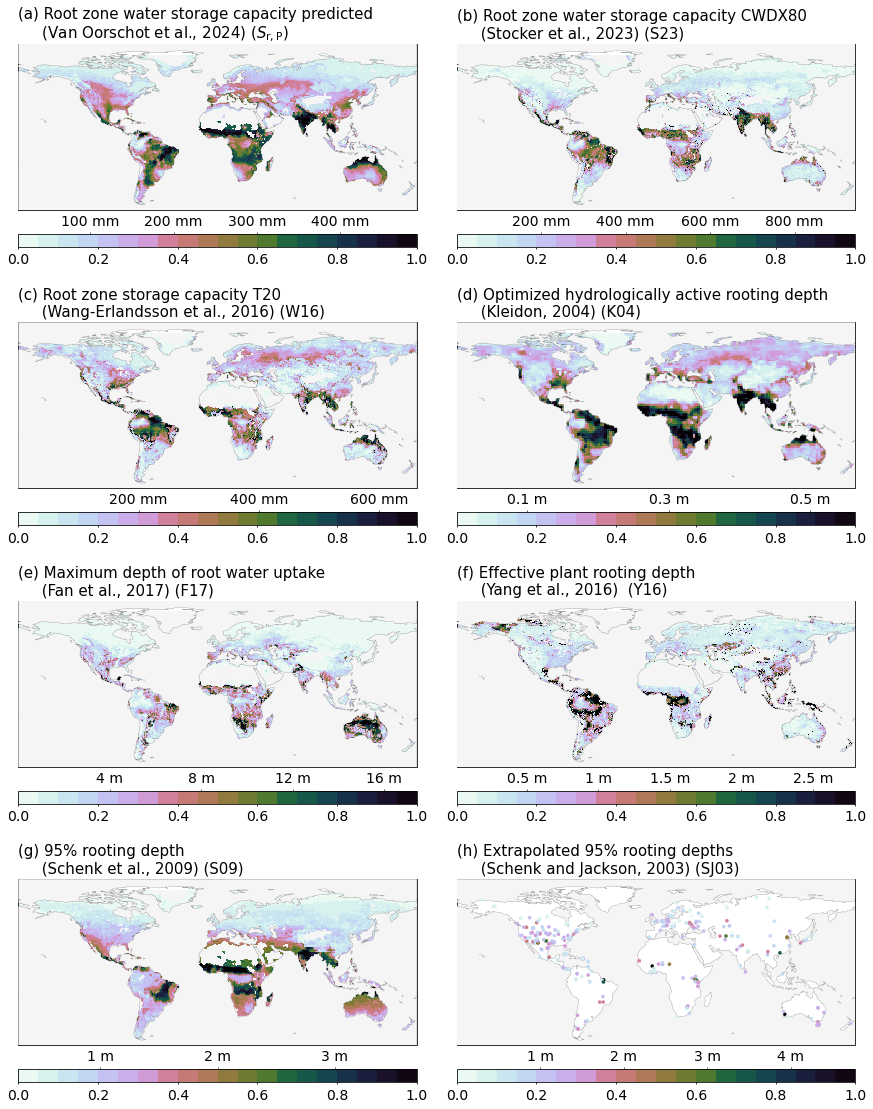

In [69]:
fig, ax = plt.subplots(4,2,figsize=(15,30),subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(hspace=-0.65,wspace=0.1)

for i in range(4):
    for j in range(2):
        m,n = i,j
        ax[m,n].coastlines(linewidth=0.1)
        ax[m,n].add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax[m,n].set_global()
        ax[m,n].set_xlim(-180,180)
        ax[m,n].set_ylim(-60,90)

# Sr predicted
bounds = np.linspace(0,1,21)
bounds2 = np.linspace(0,1,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = p.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_srp, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_srp, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(a) Root zone water storage capacity predicted \n     (Van Oorschot et al., 2024) ($S_\mathrm{r,P}$)',size=15, loc='left')

# Sr Stocker
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,1
a = s.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_s, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_s, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title(f'(b) Root zone water storage capacity CWDX80 \n     (Stocker et al., 2023) (S23)',size=15, loc='left')

# Sr Lan
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,0
a = l.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_l, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_l, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(c) Root zone storage capacity T20 \n     (Wang-Erlandsson et al., 2016) (W16)',size=15, loc='left')

# root depth opt Kleidon
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,1
a = ko.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_k, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_k, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(d) Optimized hydrologically active rooting depth \n     (Kleidon, 2004) (K04)',size=15, loc='left')

# fan
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=2,0
a = f.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_f, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_f, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(e) Maximum depth of root water uptake \n     (Fan et al., 2017) (F17)',size=15, loc='left')

# yang
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=2,1
a = ya.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_y, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_y, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(f) Effective plant rooting depth \n     (Yang et al., 2016)  (Y16)',size=15, loc='left')

# Schenk 2009
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=3,0
a = sc.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_sc, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_sc, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(g) 95% rooting depth \n     (Schenk et al., 2009) (S09)',size=15, loc='left')

# Schenk points
m,n=3,1
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
sp = ax[m,n].scatter(sjj.Longitude,sjj.Latitude,s=12,c=sjj.D95_extrapolated_norm,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_sjj, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_sjj, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(h) Extrapolated 95% rooting depths \n     (Schenk and Jackson, 2003) (SJ03)',size=15,loc='left')

fig.savefig(f'{fig_dir}/fig07.jpg',bbox_inches='tight',dpi=600)


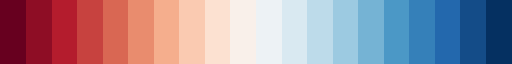

In [70]:
cmap = cm.get_cmap('RdBu', 20)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmd = ListedColormap(color_list)
cmd.set_bad('lightgrey')
cmd

Text(0.0, 1.0, '(g) (Schenk and Jackson, 2003)-$S_\\mathrm{r,P}$ (-)')

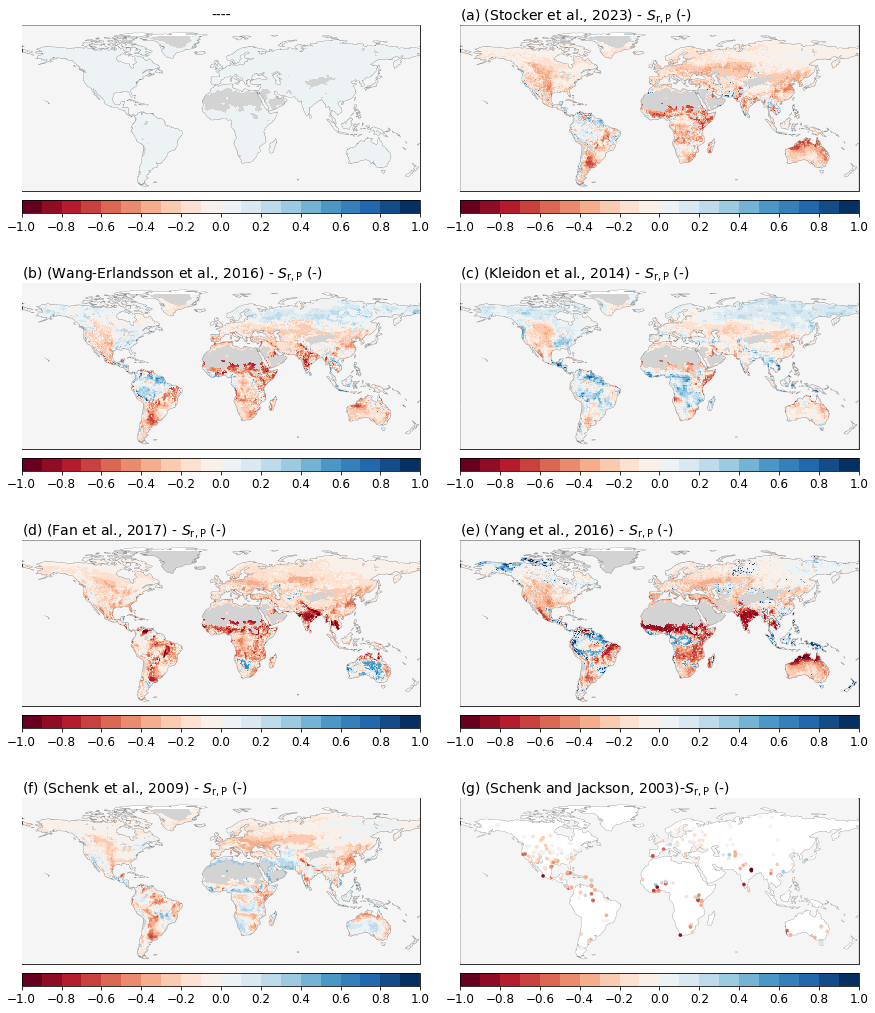

In [71]:
# diff maps
# single figure of maps
fig, ax = plt.subplots(4,2,figsize=(15,30),subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(hspace=-0.7,wspace=0.1)

for i in range(4):
    for j in range(2):
        m,n = i,j
        ax[m,n].coastlines(linewidth=0.1)
        ax[m,n].add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax[m,n].set_global()
        ax[m,n].set_xlim(-180,180)
        ax[m,n].set_ylim(-60,90)

bounds = np.linspace(-1,1,21)
bounds2 = np.linspace(-1,1,11)
norm = mpl.colors.BoundaryNorm(bounds, cmd.N)        
        
m,n=0,0
d = p - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('----',size=14)

# Sr Stocker
m,n=0,1
d = s - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(a) (Stocker et al., 2023) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Sr Lan
m,n=1,0
d = l - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(b) (Wang-Erlandsson et al., 2016) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# root depth opt Kleidon
m,n=1,1
d = ko - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(c) (Kleidon et al., 2014) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Fan
m,n=2,0
d = f - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(d) (Fan et al., 2017) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Yang
m,n=2,1
d = ya - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(e) (Yang et al., 2016) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Schenk 2009
m,n=3,0
d = sc - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(f) (Schenk et al., 2009) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Schenk points
m,n=3,1
d = sjj['D95_extrapolated_norm'] - sjj['sr_p_norm']
sp = ax[m,n].scatter(sjj.Longitude,sjj.Latitude,s=12,c=d,edgecolors='face',marker='o',linewidths=0.1,cmap=cmd,norm=norm,zorder=102)
cbar = plt.colorbar(sp, ax=ax[m,n], orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='', size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(g) (Schenk and Jackson, 2003)-$S_\mathrm{r,P}$ (-)',size=14, loc='left')

## CORRELATIONS

In [72]:
rp_table = compute_corr_tables()[0]
rs_table = compute_corr_tables()[1]

df_rp = pd.DataFrame(data = rp_table,index=['$S_\mathrm{r,P}$ (mm)','Stocker et al. (2023)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'],
                   columns = ['$S_\mathrm{r,P}$ (mm)','Stocker et al. (2023)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Kleidon (2004) (m)','Yang et al. (2016) (m)','Schenk and Jackson (2003) (m)'])
df_rs = pd.DataFrame(data = rs_table,index=['$S_\mathrm{r,P}$ (mm)','Stocker et al. (2023)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'],
                   columns = ['$S_\mathrm{r,P}$ (mm)','Stocker et al. (2023)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'])

In [73]:
# pearson
df_rp

,"$S_\mathrm{r,P}$ (mm)",Stocker et al. (2023),Wang-Erlandsson et al. (2016) (mm),Fan et al. (2017) (m),Schenk et al. (2009) (m),Kleidon (2004) (m),Yang et al. (2016) (m),Schenk and Jackson (2003) (m)
"$S_\mathrm{r,P}$ (mm)",1.00,0.67,0.55,0.56,0.64,-0.01,0.71,0.23
Stocker et al. (2023),0.67,1.00,0.63,0.46,0.52,0.05,0.66,0.11
Wang-Erlandsson et al. (2016) (mm),0.55,0.63,1.00,0.33,0.42,0.06,0.66,0.05
Fan et al. (2017) (m),0.56,0.46,0.33,1.00,0.43,-0.03,0.42,0.12
Schenk et al. (2009) (m),0.64,0.52,0.42,0.43,1.00,0.00,0.57,0.22
Yang et al. (2016) (m),-0.01,0.05,0.06,-0.03,0.00,1.00,-0.02,0.21
Kleidon (2004) (m),0.71,0.66,0.66,0.42,0.57,-0.02,1.00,0.11
Schenk and Jackson (2003) (m),0.23,0.11,0.05,0.12,0.22,0.21,0.11,1.00


In [74]:
# spearman
df_rs

,"$S_\mathrm{r,P}$ (mm)",Stocker et al. (2023),Wang-Erlandsson et al. (2016) (mm),Fan et al. (2017) (m),Schenk et al. (2009) (m),Yang et al. (2016) (m),Kleidon (2004) (m),Schenk and Jackson (2003) (m)
"$S_\mathrm{r,P}$ (mm)",1.00,0.75,0.49,0.76,0.77,-0.00,0.59,0.23
Stocker et al. (2023),0.75,1.00,0.64,0.70,0.72,0.07,0.65,0.15
Wang-Erlandsson et al. (2016) (mm),0.49,0.64,1.00,0.45,0.35,0.03,0.63,0.04
Fan et al. (2017) (m),0.76,0.70,0.45,1.00,0.71,0.04,0.51,0.22
Schenk et al. (2009) (m),0.77,0.72,0.35,0.71,1.00,0.05,0.51,0.21
Yang et al. (2016) (m),-0.00,0.07,0.03,0.04,0.05,1.00,0.06,0.04
Kleidon (2004) (m),0.59,0.65,0.63,0.51,0.51,0.06,1.00,0.12
Schenk and Jackson (2003) (m),0.23,0.15,0.04,0.22,0.21,0.04,0.12,1.00


In [75]:
rpw_table = compute_corr_tables_weighted()[0]
rsw_table = compute_corr_tables_weighted()[1]

df_rpw = pd.DataFrame(data = rpw_table,index=['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'],
                   columns = ['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Kleidon (2004) (m)','Yang et al. (2016) (m)','Schenk and Jackson (2003) (m)'])
df_rsw = pd.DataFrame(data = rsw_table,index=['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'],
                   columns = ['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'])

In [76]:
df_rpw

,Sr_p (mm),Stocker et al. (2023) (mm),Wang-Erlandsson et al. (2016) (mm),Fan et al. (2017) (m),Schenk et al. (2009) (m),Kleidon (2004) (m),Yang et al. (2016) (m),Schenk and Jackson (2003) (m)
Sr_p (mm),1.00,0.63,0.53,0.51,0.60,-0.02,0.70,0.23
Stocker et al. (2023) (mm),0.63,1.00,0.62,0.40,0.47,0.05,0.64,0.11
Wang-Erlandsson et al. (2016) (mm),0.53,0.62,1.00,0.30,0.39,0.07,0.65,0.05
Fan et al. (2017) (m),0.51,0.40,0.30,1.00,0.37,-0.04,0.38,0.12
Schenk et al. (2009) (m),0.60,0.47,0.39,0.37,1.00,-0.00,0.53,0.22
Yang et al. (2016) (m),-0.02,0.05,0.07,-0.04,-0.00,1.00,-0.02,0.21
Kleidon (2004) (m),0.70,0.64,0.65,0.38,0.53,-0.02,1.00,0.11
Schenk and Jackson (2003) (m),0.23,0.11,0.05,0.12,0.22,0.21,0.11,1.00


In [77]:
# change order of columns and rows
df_rsw = df_rsw.reindex(['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Kleidon (2004) (m)','Fan et al. (2017) (m)','Yang et al. (2016) (m)','Schenk et al. (2009) (m)','Schenk and Jackson (2003) (m)'])
df_rsw = df_rsw[['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Kleidon (2004) (m)','Fan et al. (2017) (m)','Yang et al. (2016) (m)','Schenk et al. (2009) (m)','Schenk and Jackson (2003) (m)']]
df_rsw

,Sr_p (mm),Stocker et al. (2023) (mm),Wang-Erlandsson et al. (2016) (mm),Kleidon (2004) (m),Fan et al. (2017) (m),Yang et al. (2016) (m),Schenk et al. (2009) (m),Schenk and Jackson (2003) (m)
Sr_p (mm),1.00,0.72,0.48,0.61,0.70,-0.02,0.73,0.23
Stocker et al. (2023) (mm),0.72,1.00,0.66,0.68,0.65,0.08,0.69,0.15
Wang-Erlandsson et al. (2016) (mm),0.48,0.66,1.00,0.64,0.43,0.05,0.32,0.04
Kleidon (2004) (m),0.61,0.68,0.64,1.00,0.51,0.07,0.50,0.12
Fan et al. (2017) (m),0.70,0.65,0.43,0.51,1.00,0.03,0.65,0.22
Yang et al. (2016) (m),-0.02,0.08,0.05,0.07,0.03,1.00,0.04,0.04
Schenk et al. (2009) (m),0.73,0.69,0.32,0.50,0.65,0.04,1.00,0.21
Schenk and Jackson (2003) (m),0.23,0.15,0.04,0.12,0.22,0.04,0.21,1.00


In [78]:
p = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')

f = xr.open_dataset(f'{work_dir}/reference_root_products/fan2017.nc') 
f = f.root_depth
f = f.where(p.sr_p[:,:]>=0)

ya = xr.open_dataset(f'{work_dir}/reference_root_products/yang2016.nc')
ya = ya.Band1
ya = ya.where(p.sr_p[:,:]>=0)

l = xr.open_dataset(f'{work_dir}/reference_root_products/wangerlandsson2016.nc')
l = l.sr_cru_20yrs[0]
l = l.where(p.sr_p[:,:]>=0)

s = xr.open_dataset(f'{work_dir}/reference_root_products/stocker2023.nc')
s = s.cwdx80
s = s.where(p.sr_p[:,:]>=0)

sc = xr.open_dataset(f'{work_dir}/reference_root_products/schenk2009.nc') 
sc = sc['95ecosys_rootdepth_1d'][0]
sc = sc.where(p.sr_p[:,:]>=0)

ko = xr.open_dataset(f'{work_dir}/reference_root_products/kleidon2004.nc')
ko = ko['rootOptMap150_m']

#Schenk and Jackson observed rooting depths
sjj = pd.read_csv(f'{work_dir}/reference_root_products/schenkjackson2003.csv',index_col=0)

In [79]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    # cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    # cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True,labelsize=14)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #          rotation_mode="anchor")
    
    plt.setp(ax.get_xticklabels(), rotation=30, ha="center", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    # ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

272
52026
272
51996
272
53937
272
52655
272
9526
272
51493
307
293


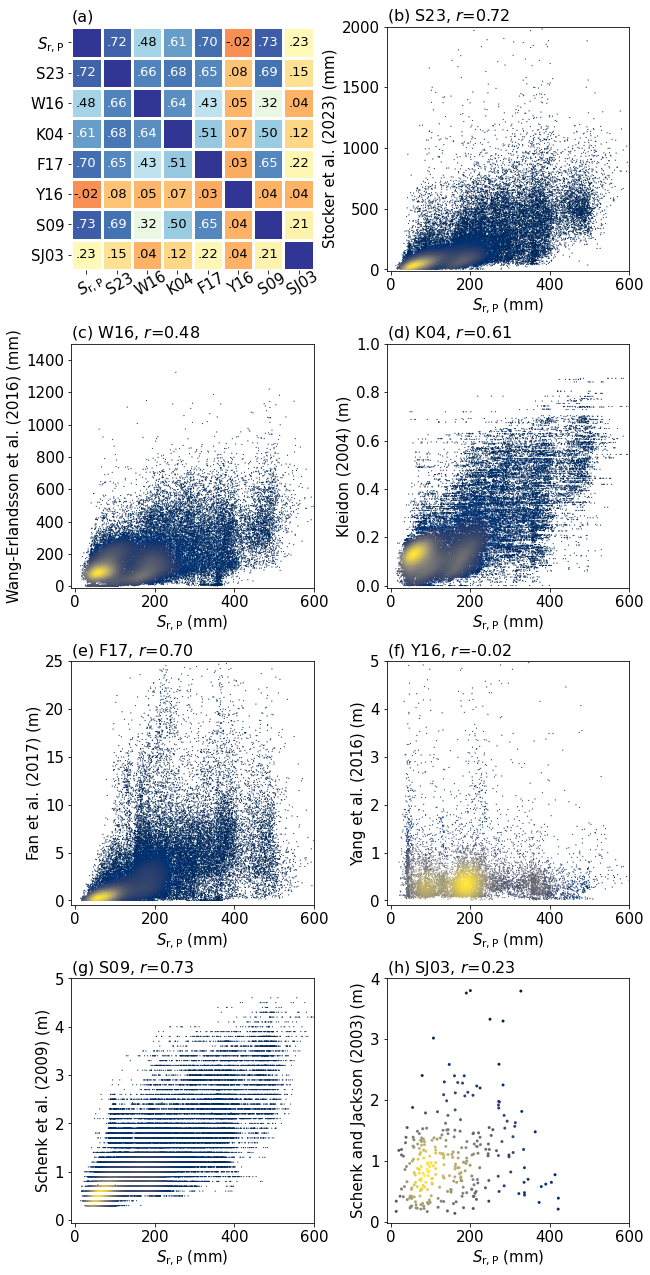

In [80]:
# PLOT

fig = plt.figure(figsize=(10,22))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

xl = ['$S_\mathrm{r,P}$','S23','W16','K04','F17','Y16','S09','SJ03']
yl = ['$S_\mathrm{r,P}$','S23','W16','K04','F17','Y16','S09','SJ03']
corr = df_rsw.copy(deep=True)
ax = fig.add_subplot(421)
im, _ = heatmap(corr, xl,yl, ax=ax,
                cmap="RdYlBu", vmin=-0.3, vmax=0.8)
ax.tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True,labelsize=15)
def func(x, pos):
    return f"{x:.2f}".replace("0.", ".").replace("1.00", "")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func),threshold=0.6, size=13)
ax.set_title('(a)',size=16,loc='left')


ax = fig.add_subplot(422)
p = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')
x=p.sr_p
print(len(x))
y = s
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Stocker et al. (2023) (mm)']
rs = df_rsw.loc['Sr_p (mm)','Stocker et al. (2023) (mm)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-10,2000)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(b) S23, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Stocker et al. (2023) (mm)',size=15)
print(len(x))

ax = fig.add_subplot(423)
p = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')
x=p.sr_p
print(len(x))
y = l
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Wang-Erlandsson et al. (2016) (mm)']
rs = df_rsw.loc['Sr_p (mm)','Wang-Erlandsson et al. (2016) (mm)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-10,1500)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(c) W16, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Wang-Erlandsson et al. (2016) (mm)',size=15)
print(len(x))

ax = fig.add_subplot(424)
p = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')
x=p.sr_p
print(len(x))
y = ko
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Kleidon (2004) (m)']
rs = df_rsw.loc['Sr_p (mm)','Kleidon (2004) (m)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.01,1)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(d) K04, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Kleidon (2004) (m)',size=15)
print(len(x))

ax = fig.add_subplot(425)
p = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')
x=p.sr_p
print(len(x))
y = f
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Fan et al. (2017) (m)']
rs = df_rsw.loc['Sr_p (mm)','Fan et al. (2017) (m)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.5,25)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(e) F17, $r$={rs}0',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Fan et al. (2017) (m)',size=15)
print(len(x))

ax = fig.add_subplot(426)
p = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')
x=p.sr_p
print(len(x))
y = ya
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Yang et al. (2016) (m)']
rs = df_rsw.loc['Sr_p (mm)','Yang et al. (2016) (m)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.1,5)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(f) Y16, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Yang et al. (2016) (m)',size=15)
print(len(x))


ax = fig.add_subplot(427)
p = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')
x=p.sr_p
print(len(x))
y = sc
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Schenk et al. (2009) (m)']
rs = df_rsw.loc['Sr_p (mm)','Schenk et al. (2009) (m)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.05,5)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(g) S09, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Schenk et al. (2009) (m)',size=15)
print(len(x))

ax = fig.add_subplot(428)
p = xr.open_dataset(f'{work_dir}/sr_predicted_map.nc')
x=sjj.sr_p.values
print(len(x))
y = sjj.D95_extrapolated.values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Schenk and Jackson (2003) (m)']
rs = df_rsw.loc['Sr_p (mm)','Schenk and Jackson (2003) (m)']
ax.scatter(x,y,c=z,s=8,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.01,4)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(h) SJ03, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Schenk and Jackson (2003) (m)',size=15)
print(len(x))

fig.savefig(f'{fig_dir}/fig08.jpg',bbox_inches='tight',dpi=600)